In [24]:
import os
import json
import glob
import copy

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

In [25]:
%matplotlib notebook

# Select data

## IGNORE THESE:
##### V1:  JC076-20190501, JC083-20190510
    - if rfs only, ignore: JC083-20190510, JC083-20190511, 
    
    - if blobs & rfs only, ignore: JC083_20190510, JC083-20190511
    
    - if ALL stimuli, ignore: JC083-20190507, JC083-20190510, 
    
#### Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if rfs only, ignore: JC078-20190504, JC078-2019513, 
                           JC083-20190512

    - if blobs & rfs: ignore: JC078-20190426, JC078-2019513
                              JC083-20190512
                              
    - if ALL stimuli, ignore: JC078-20190430, JC078-20190426, JC078-20190504
                              JC083-20190508
#### Li:  JC076-20190422, JC099-20190609, JC091-20190607, JC091-20190606
    

In [26]:
# always_exclude = ['JC076-20190501', 'JC083-20190510', 
#                   'JC078-20190509', 'JC080-20190506', 'JC083-20190517', 'JC078-20190426',
#                  'JC076-20190422', 'JC099-20190609', 'JC091-20190607', 'JC091-20190606']
also_exclude = []
# also_exclude = ['JC083-20190510', 'JC083-20190511', 
#                 'JC078-20190504', 'JC078-2019513',
#                 'JC083-20190512']

always_exclude = ['JC078-20190426'] #, 'JC092-20190527', 'JC076-20190422'] #, 'JC089-20190522?']
# also_exclude = ['JC099-20190617', 'JC099-20190609',
#                 'JC091-20190607', 'JC091-20190606']
#                 'JC083-20190507', 'JC083-20190510', 
#                 'JC078-20190430', 'JC078-20190504',
#                 'JC083-20190512',
#                 'JC076-20190420'] # Repeats
                

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

1


# Set responsivity params

In [27]:
responsive_test = None
responsive_thr = None
n_stds = None
experiment_type = 'rfs'

# Get aggregate data

In [28]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [10]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)


In [11]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-all


In [12]:
#dsets = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])] #experiment_type]

In [13]:
included_ixs = []
for (animalid, session, fovnum), g in sdata.groupby(['animalid', 'session', 'fovnum']):
    if ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values) \
    and ('blobs' in g['experiment'].values and 'gratings' in g['experiment'].values):
        included_ixs.extend(g.index)
        

In [14]:
dsets = sdata.loc[included_ixs]

# Create output dir for analysis


In [29]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [16]:
fit_desc = fitrf.get_fit_desc(response_type=response_type)
print fit_desc

fit-2dgaus_dff-no-cutoff


In [17]:
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s-%s' % (traceid, fit_desc), 'scatter')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/scatter


In [18]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [19]:
# Set plotting params
threshold_dff = False
min_dff = 0
cmap = 'inferno'


In [37]:
def get_rfdata(sdata, fit_desc=None, excluded_sessions=[]):
    assert fit_desc is not None, "No fit-desc specified!"
    
    rfdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
    for skey in excluded_sessions:
        animalid, session = skey.split('-')
        drop_ixs = rfdata[(rfdata['animalid']==animalid) & (rfdata['session']==session)].index.tolist()
        rfdata= rfdata.drop(drop_ixs)
            
    fit_these = []
    dpaths = {}
    unknown = []
    for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']): #animalid in rfdata['animalid'].unique():
        skey = '-'.join([animalid, session])
        if skey in excluded_sessions:
            continue

        rfruns = g['experiment'].unique()

        for rfname in rfruns:
            if int(session) < 20190511:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_gratings*', 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            else:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_%s_*' % rfname, 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            if len(fpath) > 0:
                assert len(fpath)==1, "TOo many paths: %s" % str(fpath)
                dpaths['-'.join([animalid, session, fov, rfname])] = fpath[0]
                
            elif len(fpath) == 0:
                fit_these.append((animalid, session, fov, rfname))
            else:
                unknown.append((animalid, session, fov, rfname))
#     nostats = []
#     for (animalid, session, fov, run_name) in fit_these:
#         nostats = resp.visualize_session_stats(animalid, session, fov, altdir=aggregate_session_dir, create_new=True)

    
    print ("N dpaths: %i, N unfit: %i, N unknown: %i" % (len(dpaths), len(fit_these), len(unknown)))
    print("--- these needs fits: ---")
    for fd in fit_these:
        print(fd)
    print("N datasets included: %i, N sessions excluded: %i" % (rfdata.shape[0], len(excluded_sessions)))
    #assert (len(dpaths) + len(fit_these) + len(unknown)) == rfdata.shape[0] - len(excluded_sessions), "There are dsets unaccounted for..."
    
    rfdata = rfdata.reset_index()
    fillpaths = ['' for _ in range(rfdata.shape[0])]
    for skey, fpath in dpaths.items():
        animalid, session, fov, rfname = skey.split('-')
        df_ix = rfdata[ (rfdata['animalid']==animalid) \
                           & (rfdata['session']==session) \
                           & (rfdata['fov']==fov) \
                           & (rfdata['experiment']==rfname)].index.tolist()[0]
        fillpaths[df_ix] = fpath
        
    rfdata['path'] = fillpaths
    
    return rfdata #, nostats

In [38]:
rfdata = get_rfdata(dsets, fit_desc=fit_desc, excluded_sessions=excluded_sessions)

N dpaths: 29, N unfit: 1, N unknown: 0
--- these needs fits: ---
('JC084', '20190525', 'FOV1_zoom2p0x', 'rfs')
N datasets included: 30, N sessions excluded: 1


In [39]:
rfdata.head()

,index,animalid,experiment,fov,session,visual_area,fovnum,path
0,136,JC078,rfs,FOV1_zoom2p0x,20190513,Lm,1,/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0...
1,143,JC080,rfs,FOV1_zoom2p0x,20190603,Lm,1,/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0...
2,160,JC083,rfs,FOV1_zoom2p0x,20190511,V1,1,/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0...
3,164,JC083,rfs,FOV1_zoom2p0x,20190512,Lm,1,/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0...
4,168,JC083,rfs,FOV1_zoom2p0x,20190517,Lm,1,/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0...


In [40]:
rfdata.iloc[0]['path']

'/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/fit_results.pkl'

# Select dataset

In [41]:
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

def regplot(x, y, data=None, x_estimator=None, x_bins=None, x_ci="ci",
            scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None,
            order=1, logistic=False, lowess=False, robust=False,
            logx=False, x_partial=None, y_partial=None,
            truncate=False, dropna=True, x_jitter=None, y_jitter=None,
            label=None, color=None, marker="o",
            scatter_kws=None, line_kws=None, ax=None):

    plotter = sns.regression._RegressionPlotter(x, y, data, x_estimator, x_bins, x_ci,
                                 scatter, fit_reg, ci, n_boot, units,
                                 order, logistic, lowess, robust, logx,
                                 x_partial, y_partial, truncate, dropna,
                                 x_jitter, y_jitter, color, label)

    if ax is None:
        ax = pl.gca()

    scatter_kws = {} if scatter_kws is None else copy.copy(scatter_kws)
    scatter_kws["marker"] = marker
    line_kws = {} if line_kws is None else copy.copy(line_kws)
    plotter.plot(ax, scatter_kws, line_kws)
    return ax, plotter



In [42]:
from pipeline.python.classifications import analyze_retino_structure as evalrfs


In [43]:
#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

In [44]:

def do_regr_on_fov(bootdata, bootcis, posdf, cond='azimuth', ci=.95, xaxis_lim=None):
    
    fig, ax = pl.subplots(figsize=(10,8))
    
    ax.set_title(cond)
    ax.set_ylabel('RF position (rel. deg.)')
    ax.set_xlabel('FOV position (um)')
    if xaxis_lim is not None:
        ax.set_xlim([0, xaxis_lim])
    
    axname = 'xpos' if cond=='azimuth' else 'ypos'
    parname = 'x0' if cond=='azimuth' else 'y0'
    
    # Get lis of cells that pass boot
    roi_list = [k for k, g in bootdata.groupby(['cell'])]  
    
    # Identify which cells fail...
    fail_rois = [r for r in posdf.index.tolist() if r not in roi_list]
    fadedf = posdf.loc[fail_rois]
    sns.regplot('%s_fov' % axname, '%s_rf' % axname, data=fadedf, color='k', marker='x', fit_reg=False,
                scatter_kws=dict(s=10, alpha=0.1), ax=ax, label='no fit')

    # Plot successes and regression with CI
    ax, plotter = regplot('%s_fov' % axname, '%s_rf' % axname, data=posdf.loc[roi_list], ci=ci*100, 
                          color='k', marker='o',
                scatter_kws=dict(s=8, alpha=.7), ax=ax, label='measured (regr: %i%% CI)' % int(ci*100) )

    # Get CIs from regression fit to "good data"
    grid, yhat, err_bands = plotter.fit_regression(grid=plotter.x)
    e1 = err_bands[0, :] # err_bands[0, np.argsort(xvals)] <- sort by xpos to plot
    e2 = err_bands[1, :] #err_bands[1, np.argsort(xvals)]
    regr_cis = np.array([(ex, ey) for ex, ey in zip(e1, e2)])
    
    # Get rois sorted by position:
    x0_meds = np.array([g[parname].mean() for k, g in bootdata.groupby(['cell'])])
    x0_lower = bootcis['%s_lower' % parname][roi_list]
    x0_upper = bootcis['%s_upper' % parname][roi_list]

    ci_intervals = bootcis['x0_upper'] - bootcis['x0_lower']
    weird = [i for i in ci_intervals.index.tolist() if ci_intervals[i] > 10]
    print(len(weird))
    rlist = [i for i in roi_list if i not in weird]
    roi_ixs = np.array([roi_list.index(i) for i in rlist])
    roi_list = np.array([i for i in roi_list if i not in weird])
    #print(regr_cis[roi_ixs])

    xvals = posdf['%s_fov' % axname][roi_list].values
    yvals = posdf['%s_rf' % axname][roi_list].values
    
    # Plot bootstrap results    
    ax.scatter(xvals, x0_meds[roi_ixs], c='k', marker='_', alpha=0.7, 
               label='bootstrapped (%i%% CI)' % int(ci*100) )
    ax.errorbar(xvals, x0_meds[roi_ixs], yerr=np.array(zip(x0_meds[roi_ixs]-x0_lower.iloc[roi_ixs], x0_upper.iloc[roi_ixs]-x0_meds[roi_ixs])).T, 
            fmt='none', color='k', alpha=0.7, lw=1)
    
    if xaxis_lim is not None:
        ax.set_xticks(np.arange(0, xaxis_lim, 100))
        
    #ax.set_ylim([-10, 40])
    sns.despine(offset=4, trim=True, ax=ax)
    ax.legend()

    # Check that values make sense
    deviants = []
    bad_fits = []
    for roi,lo,up,(regL, regU), med in zip(roi_list, x0_lower.iloc[roi_ixs], x0_upper.iloc[roi_ixs], regr_cis[roi_ixs], yvals):
        if (lo <= med <= up):
            if ((regL > lo and regL > up) or (regU < lo and regU < up)):
                #print(lo, med, up)
                xv = posdf['%s_fov' % axname][roi]
                yv = posdf['%s_rf' % axname][roi]
                ax.plot(xv, yv, marker='o', markersize=5, color='magenta', alpha=0.8)
                ax.plot(xv, yv, marker='x', markersize=5, color='magenta', alpha=1.0)
                deviants.append(roi)
        else:
            # Measured not within CIs
            bad_fits.append(roi)
   
    return fig, regr_cis, deviants, bad_fits


In [54]:
reload(evalrfs)
reload(util)

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.pyc'>

In [45]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


In [48]:
devpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*', 
                       'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 'evaluation', 'deviants.json'))[0]
with open(devpath, 'r') as f:
    deviants = json.load(f)


In [54]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [56]:
deviants.keys()


[u'bad_rois', u'elevation', u'pass_rois', u'azimuth']

In [58]:
[r for r in deviants['azimuth'] if r not in deviants['pass_rois']]

[0,
 5,
 12,
 21,
 25,
 36,
 43,
 69,
 70,
 78,
 91,
 93,
 97,
 101,
 112,
 134,
 142,
 147,
 148,
 150,
 155,
 165,
 166,
 168,
 194,
 205,
 216,
 234]

In [55]:
dev_both = intersection(deviants['azimuth'], deviants['elevation'])
dev_both

[112, 216, 234, 43]

In [27]:
# rfname = 'rfs'

# exp = util.ReceptiveFields(rfname, animalid, session, fov,
#                            traceid=traceid) #, trace_type='dff')
# exp.print_info()

# statsdir, stats_desc = util.create_stats_dir(exp.animalid, exp.session, exp.fov,
#                                               traceid=exp.traceid, trace_type=exp.trace_type,
#                                               response_type=response_type, 
#                                               responsive_test=None, responsive_thr=0)

# if not os.path.exists(os.path.join(statsdir, 'receptive_fields')):
#     os.makedirs(os.path.join(statsdir, 'receptive_fields'))
# print("Saving stats output to: %s" % statsdir)    


In [28]:
dsets[dsets['animalid']=='JC083']

,animalid,experiment,fov,session,visual_area,fovnum
157,JC083,blobs,FOV1_zoom2p0x,20190507,V1,1
158,JC083,retino,FOV1_zoom2p0x,20190507,V1,1
159,JC083,rfs,FOV1_zoom2p0x,20190507,V1,1
172,JC083,blobs,FOV1_zoom2p0x,20190508,Lm,1
173,JC083,retino,FOV1_zoom2p0x,20190508,Lm,1
174,JC083,rfs,FOV1_zoom2p0x,20190508,Lm,1
154,JC083,blobs,FOV1_zoom2p0x,20190510,V1,1
155,JC083,retino,FOV1_zoom2p0x,20190510,V1,1
156,JC083,rfs,FOV1_zoom2p0x,20190510,V1,1
160,JC083,rfs,FOV1_zoom2p0x,20190511,V1,1


In [29]:
excluded_sessions

['JC078-20190426',
 'JC092-20190527',
 'JC099-20190617',
 'JC099-20190609',
 'JC091-20190607',
 'JC091-20190606',
 'JC083-20190507',
 'JC083-20190510',
 'JC078-20190430',
 'JC078-20190504',
 'JC083-20190512',
 'JC076-20190420']

# Do all fovs

... [JC090|20190605|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


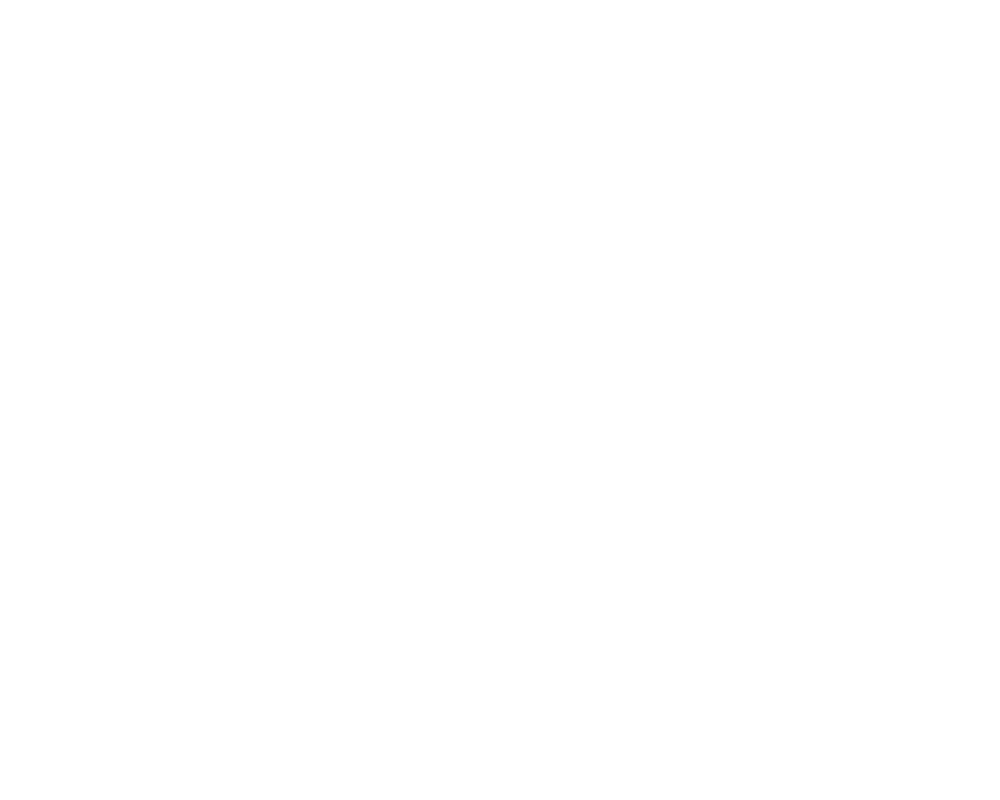

10


<IPython.core.display.Javascript object>


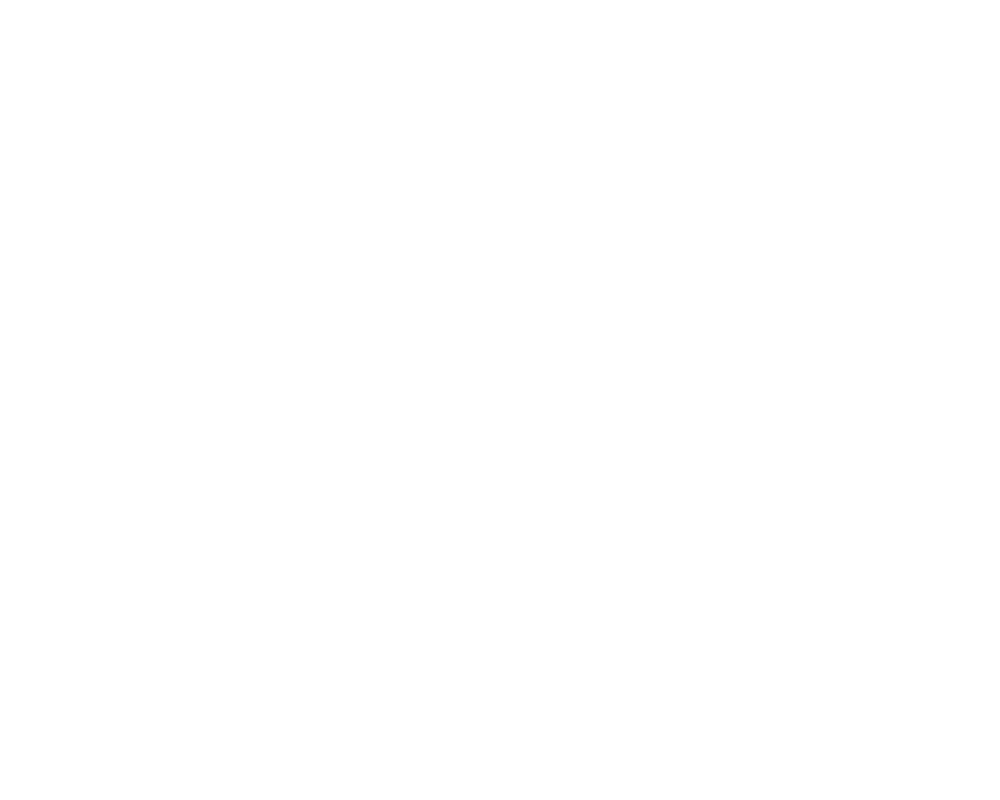

10
... [JC091|20190602|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


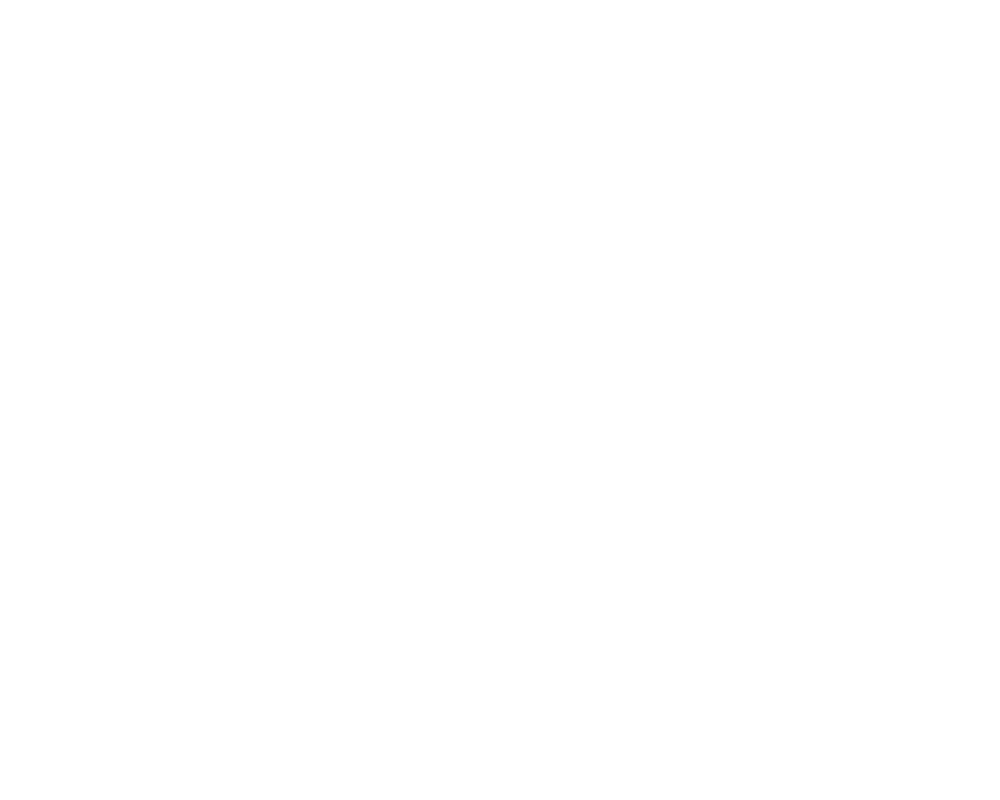

6


<IPython.core.display.Javascript object>


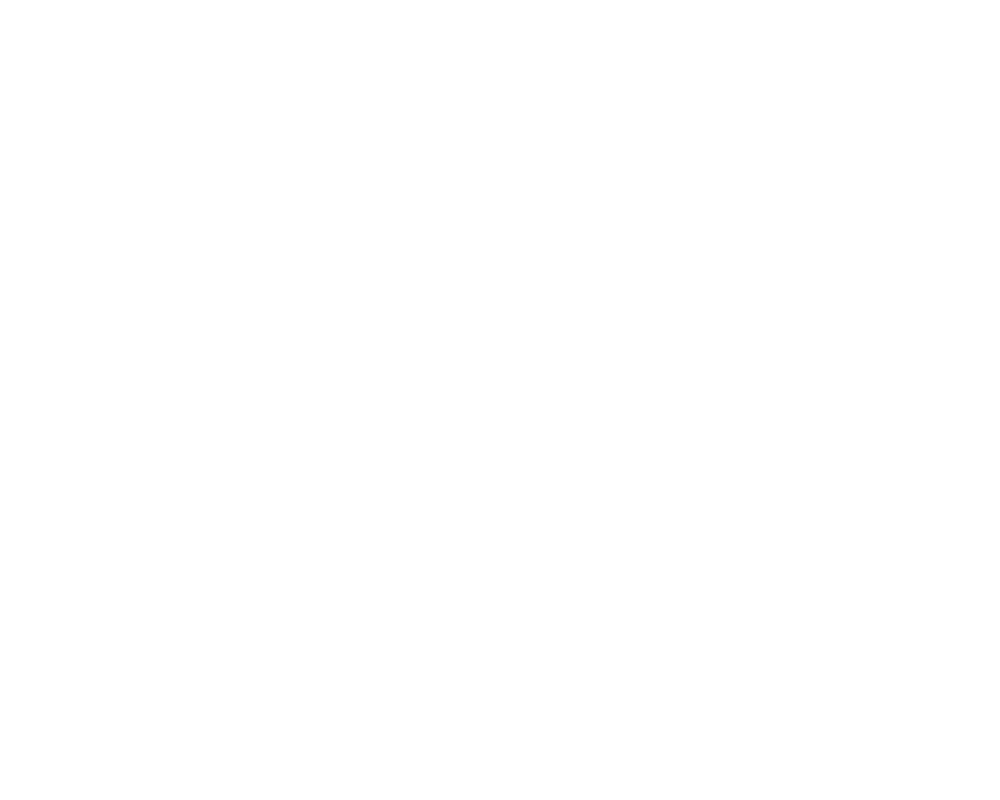

6
... [JC091|20190602|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


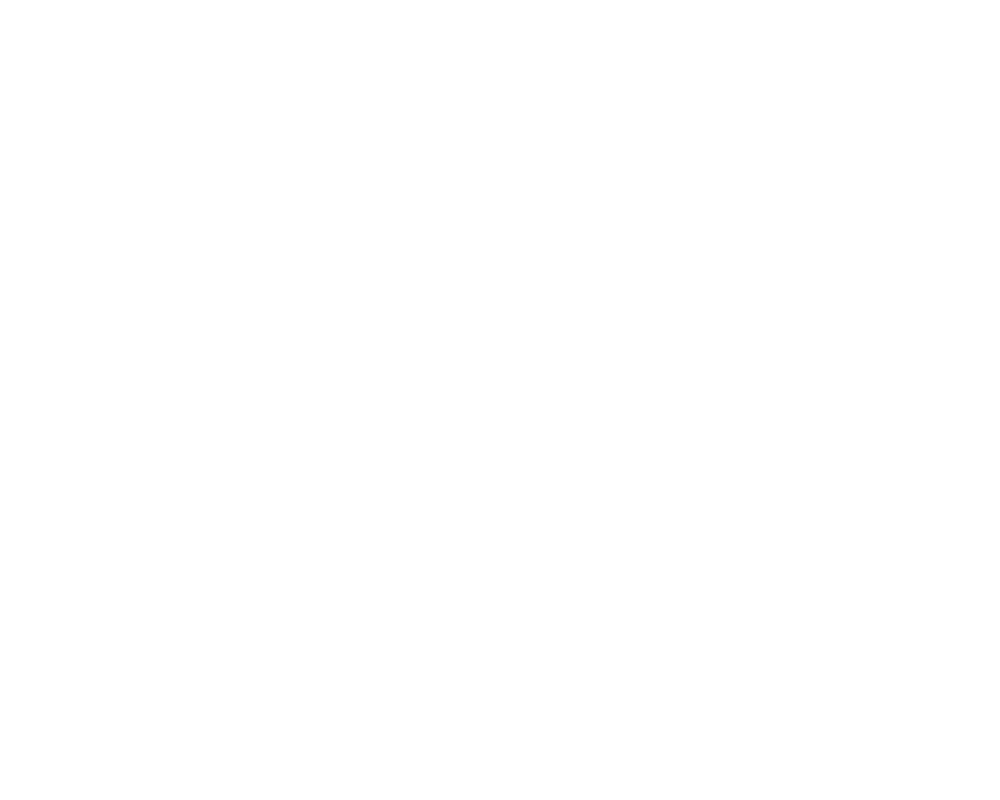

27


<IPython.core.display.Javascript object>


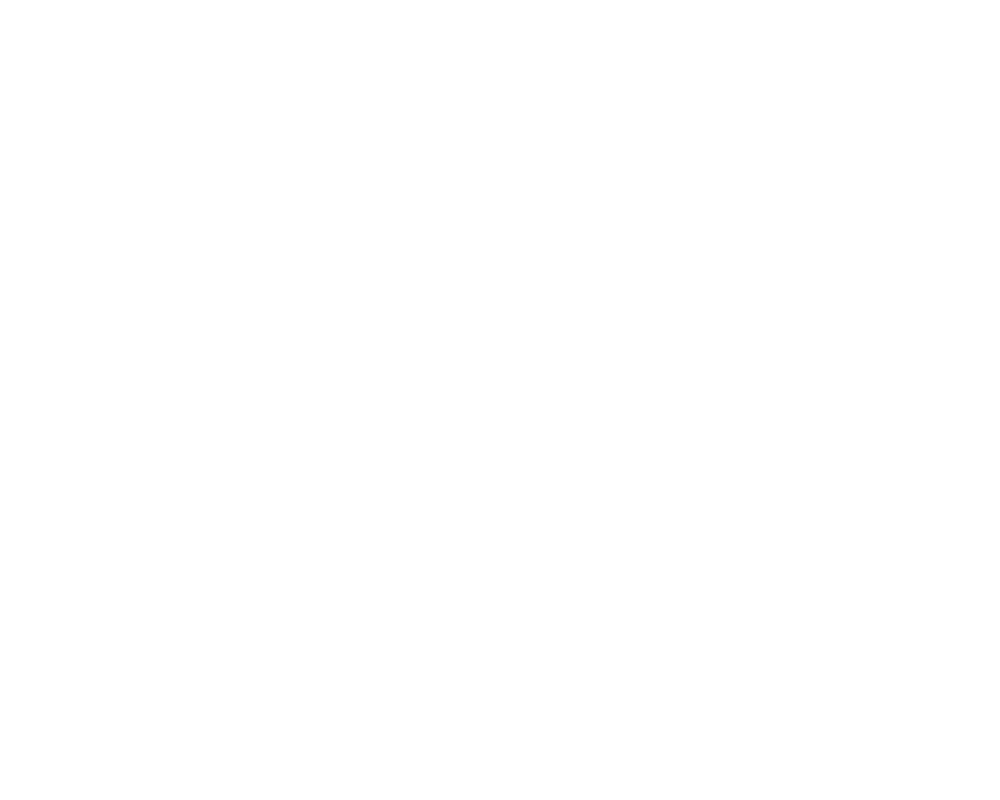

27
... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


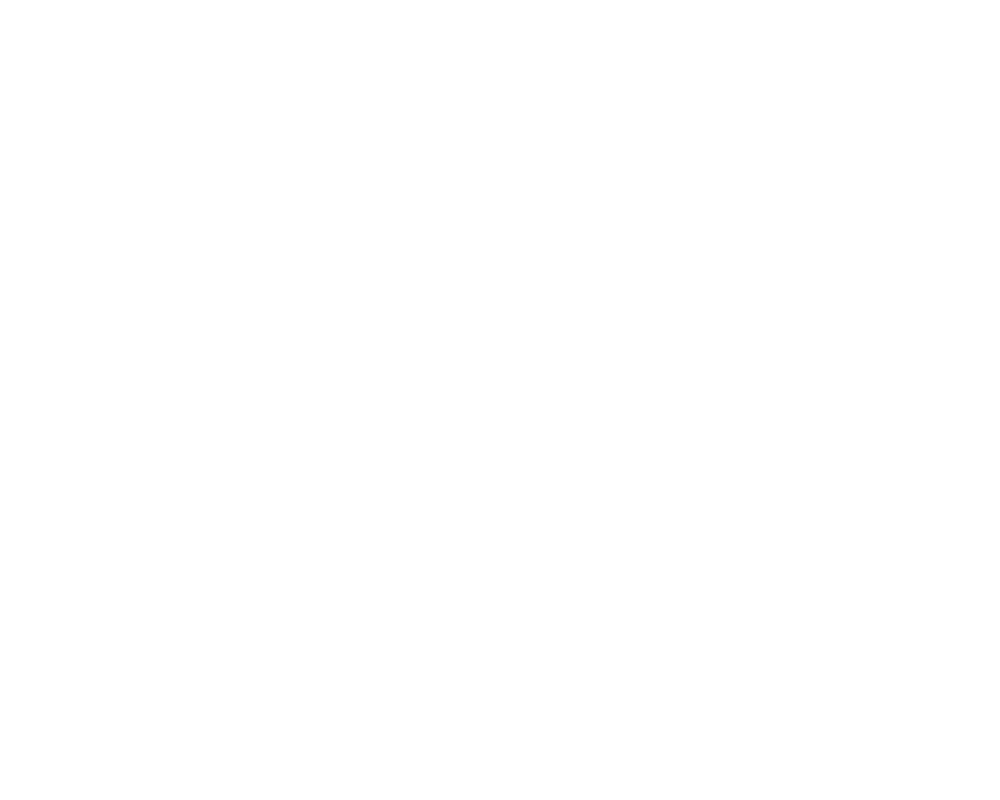

25


<IPython.core.display.Javascript object>


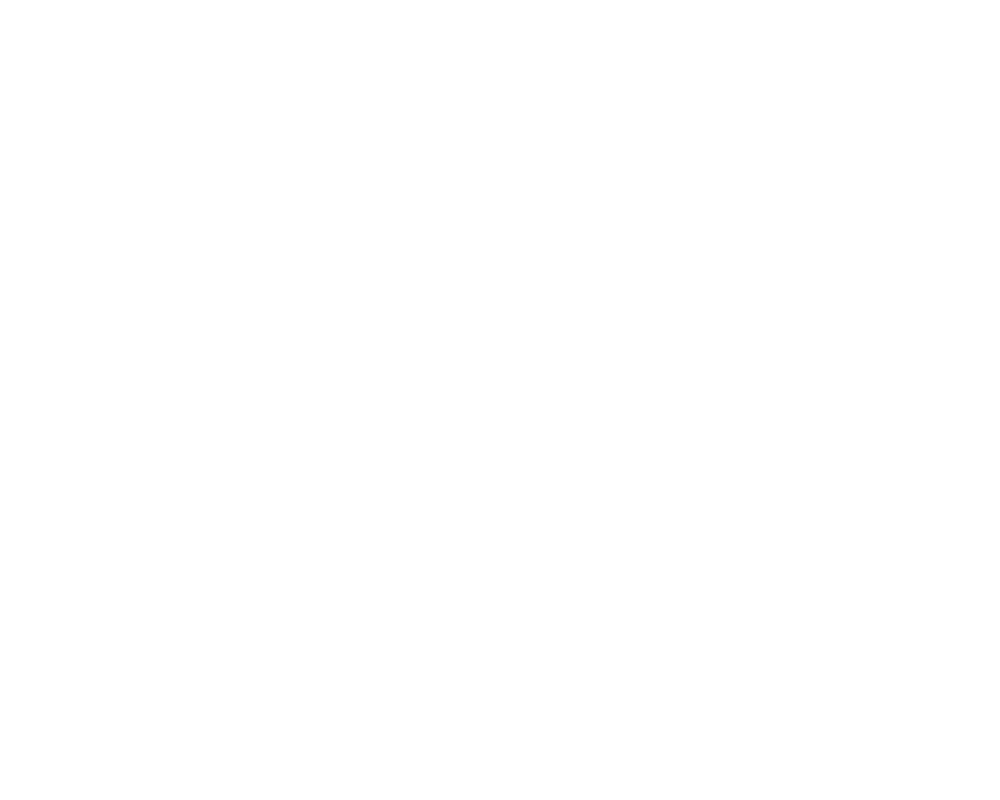

25
... [JC091|20190607|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


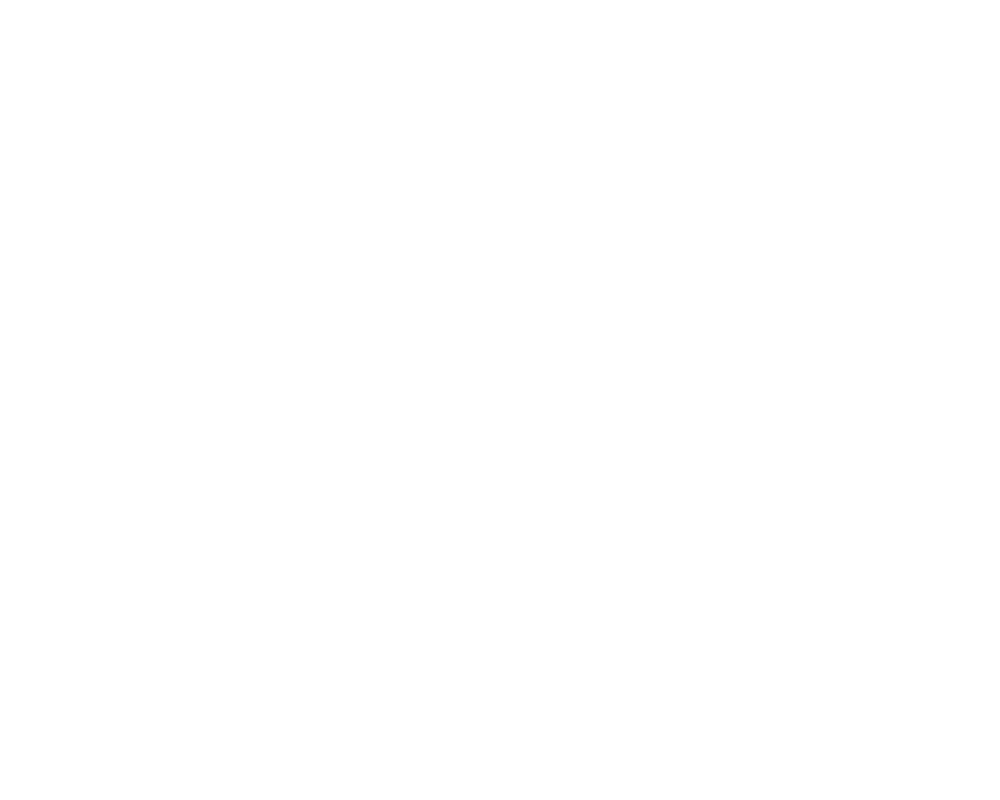

40


<IPython.core.display.Javascript object>


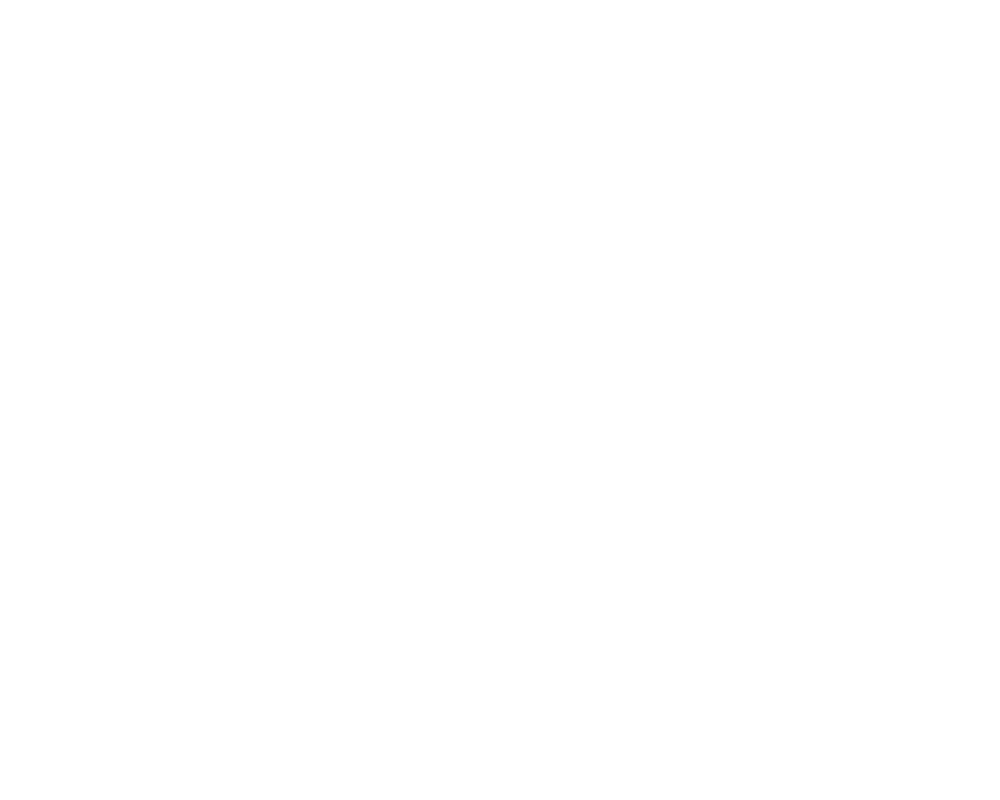

40
... [JC091|20190614|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


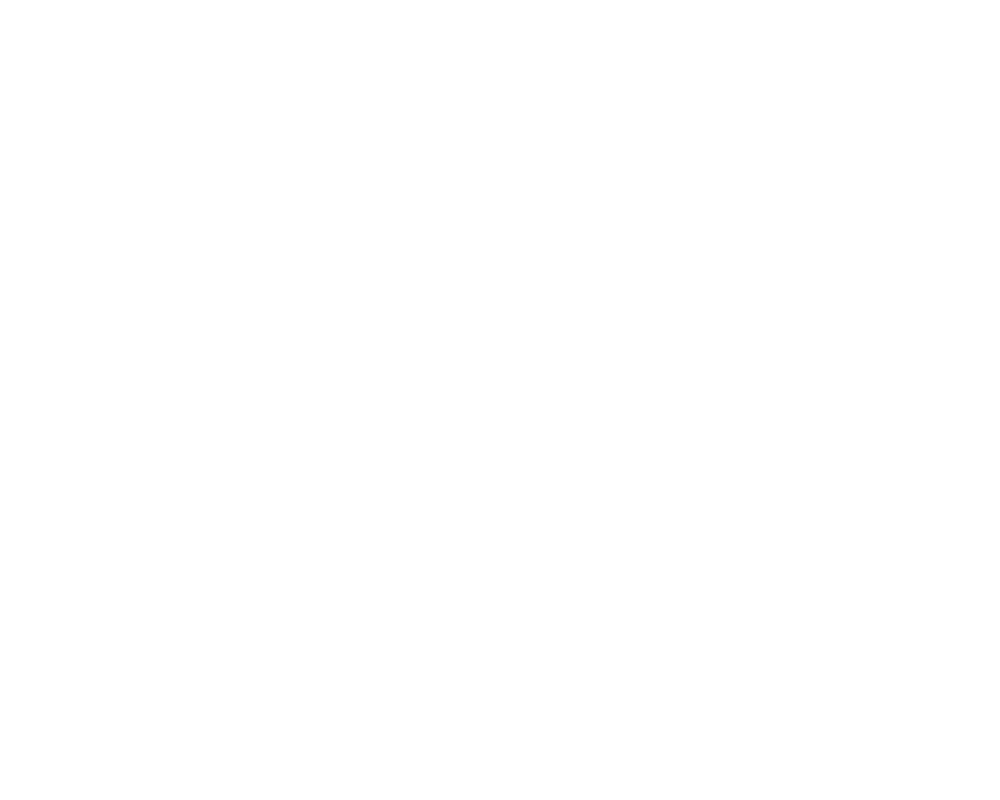

47


<IPython.core.display.Javascript object>


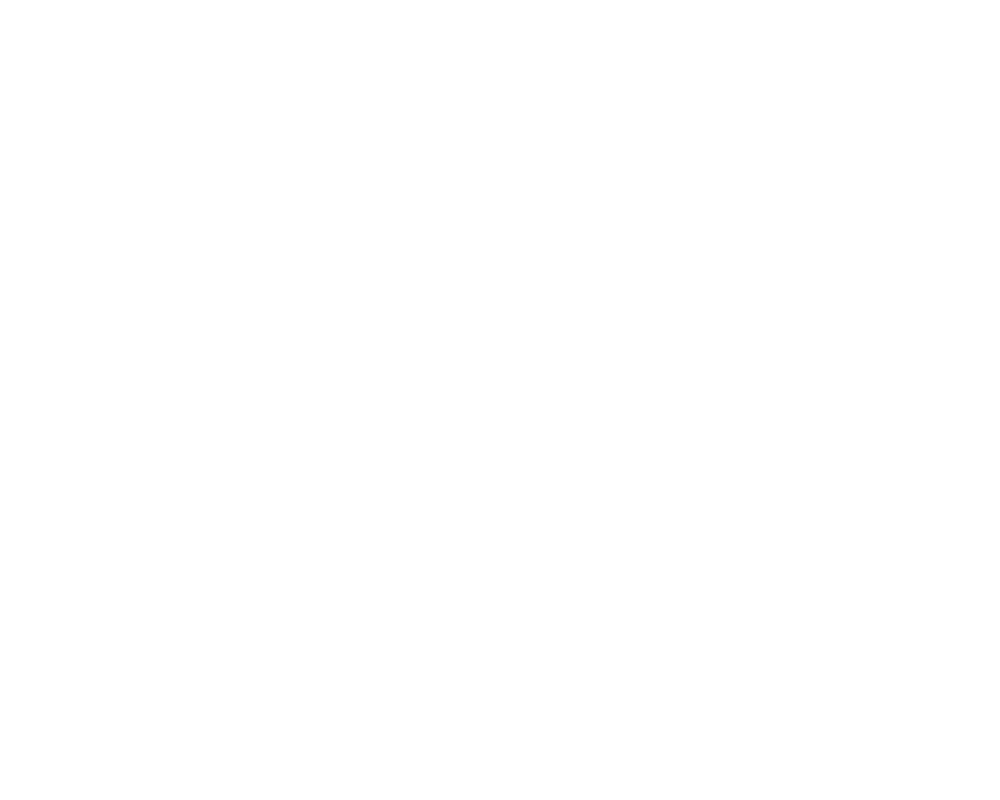

47
... [JC091|20191008|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC091/20191008/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


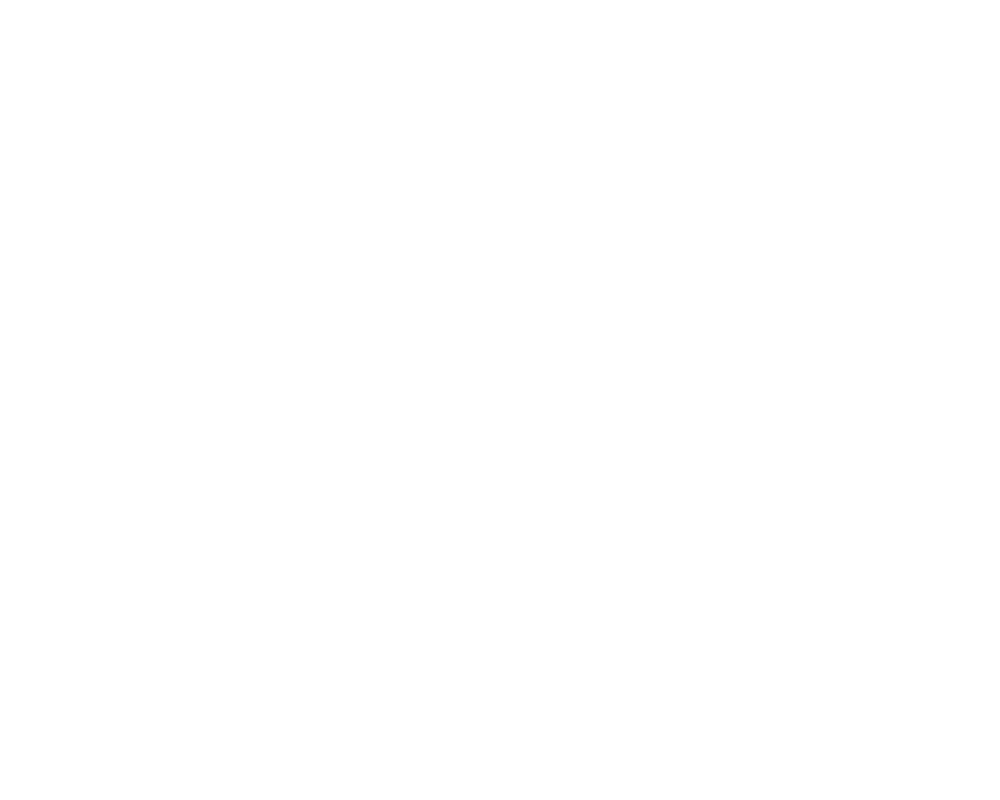

33


<IPython.core.display.Javascript object>


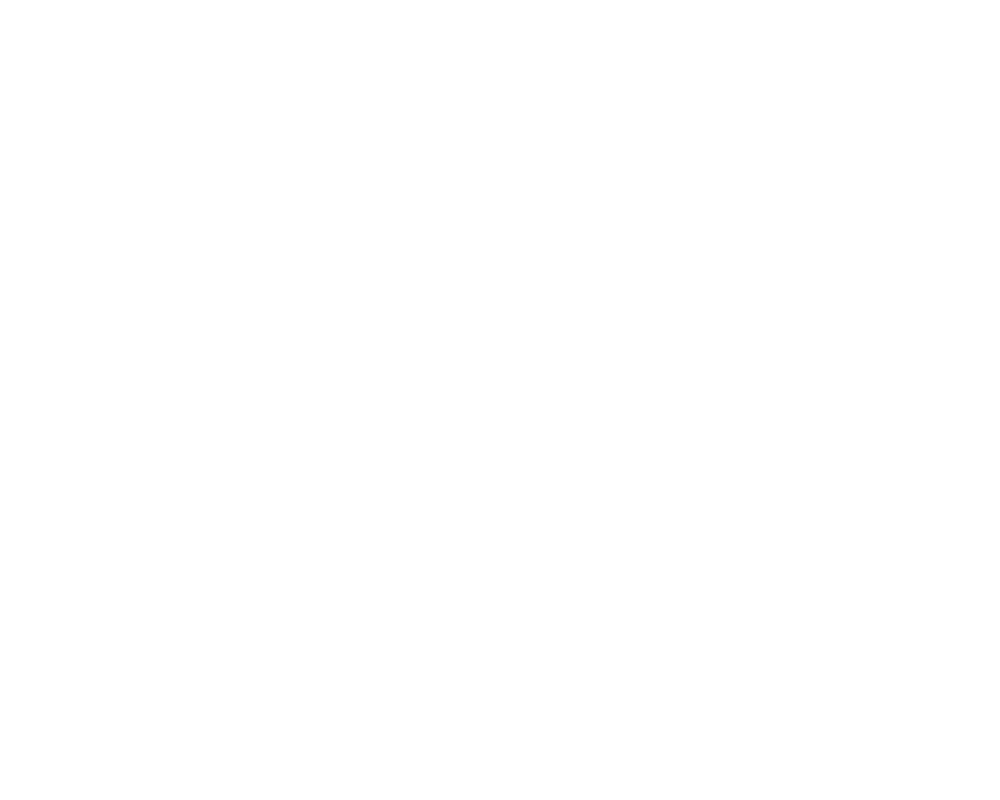

33
... [JC099|20190609|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


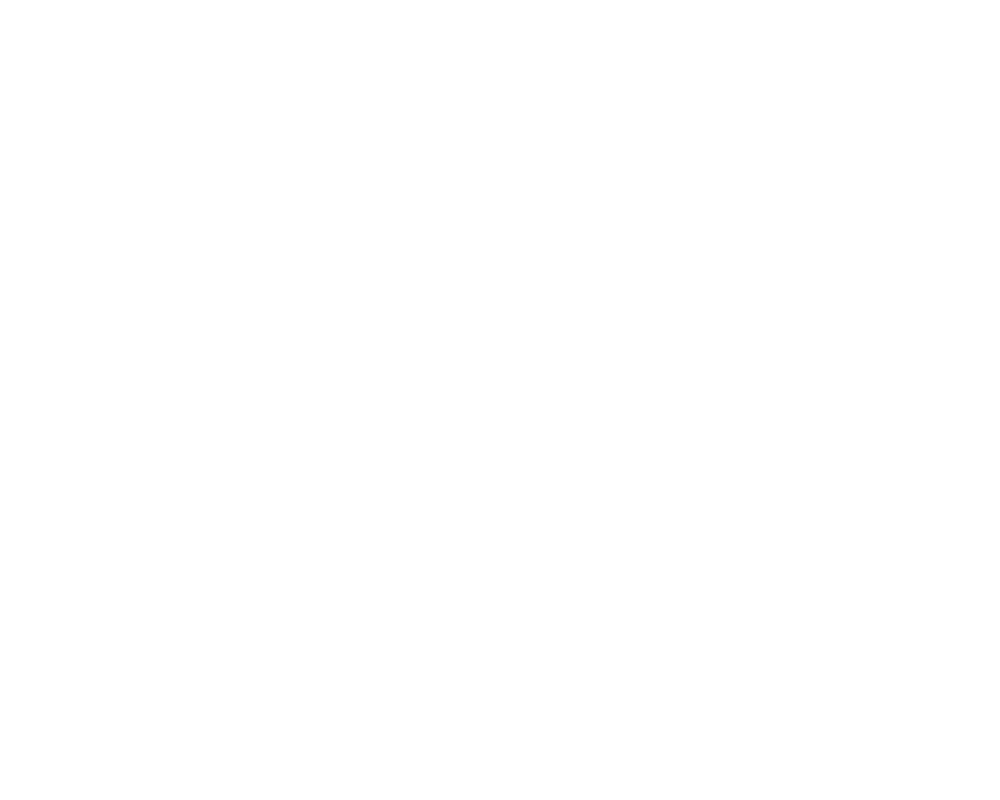

26


<IPython.core.display.Javascript object>


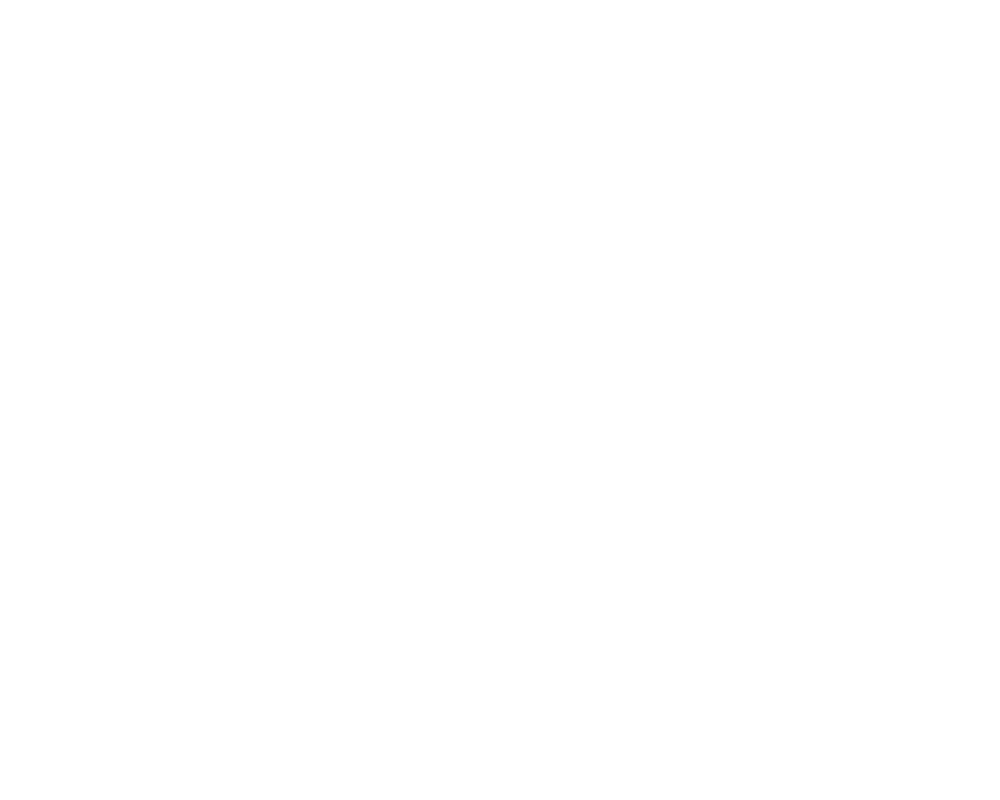

26
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


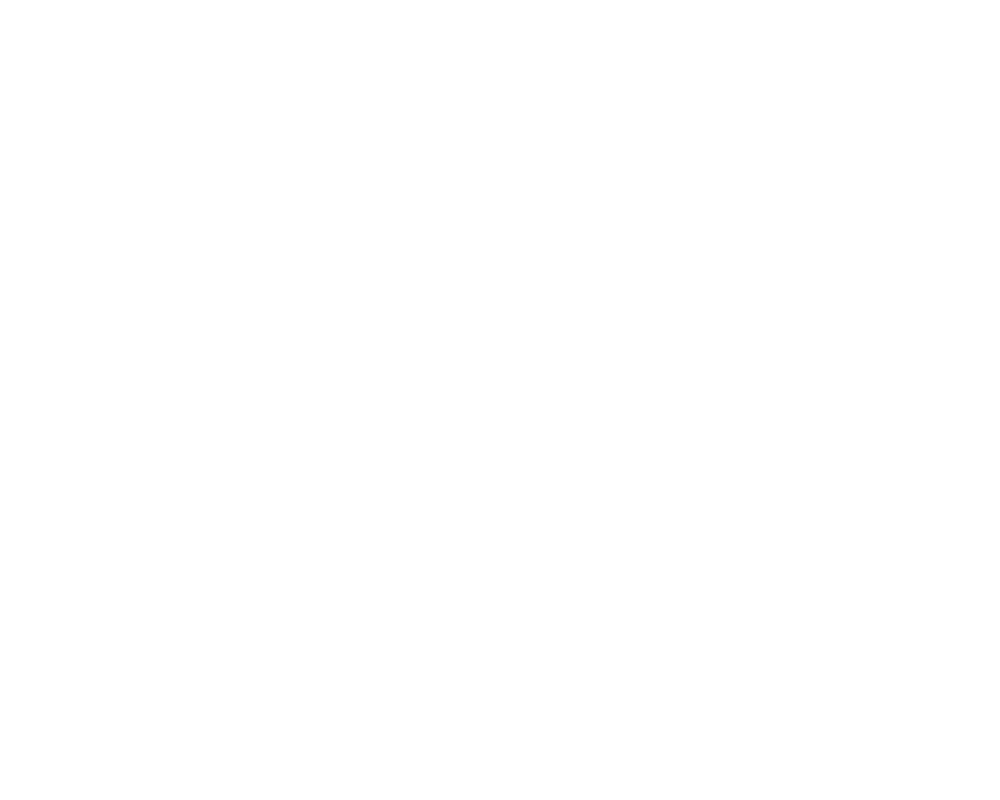

26


<IPython.core.display.Javascript object>


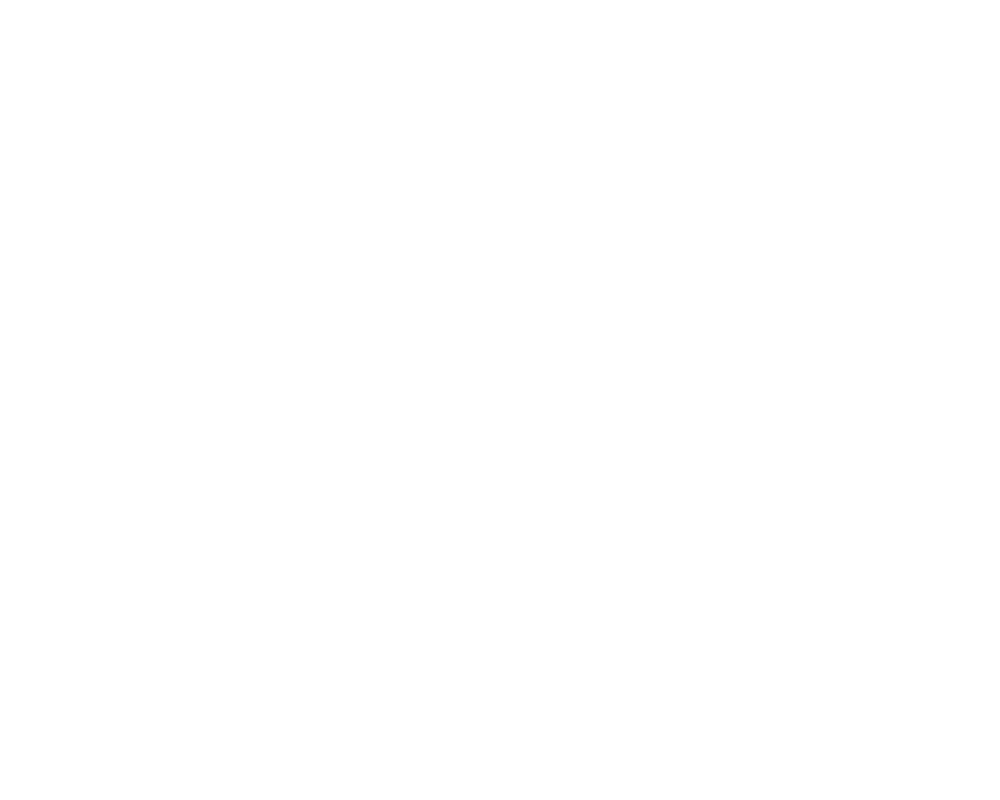

26
... [JC099|20190617|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


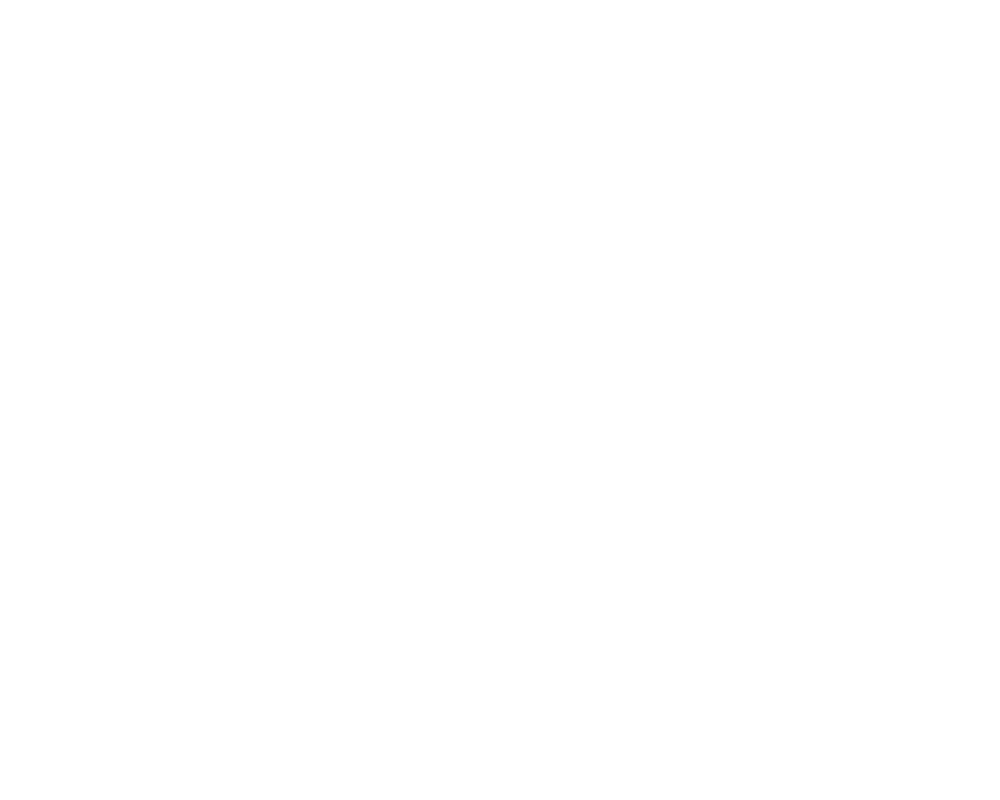

10


<IPython.core.display.Javascript object>


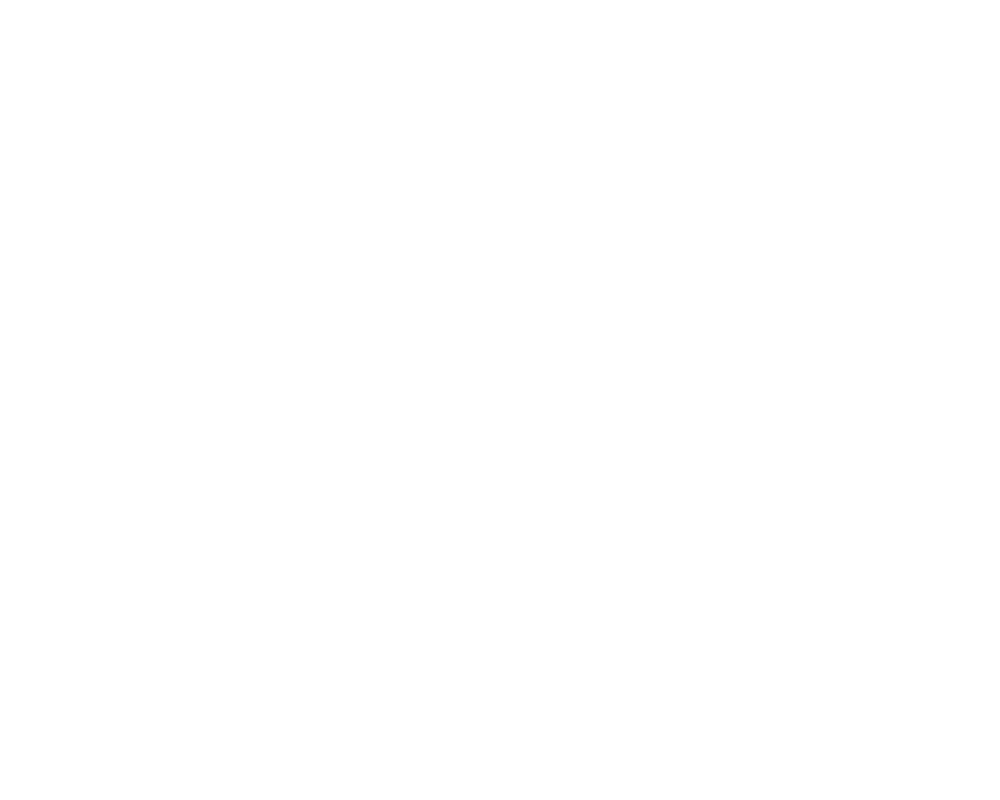

10
... [JC113|20191018|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


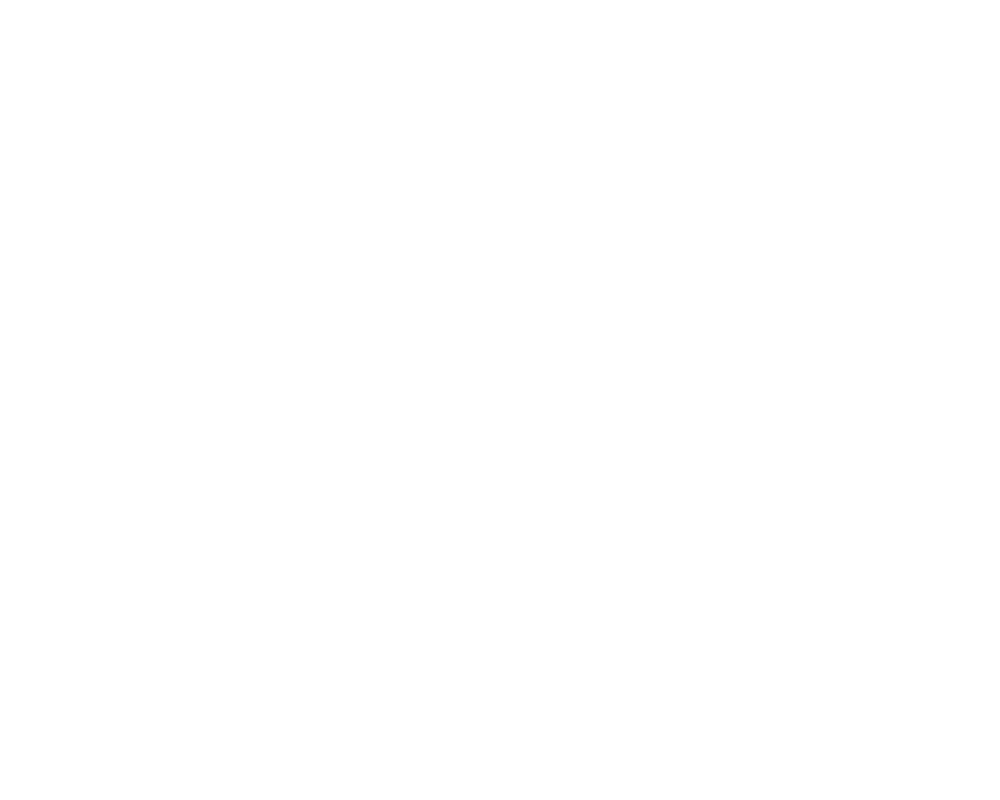

10


<IPython.core.display.Javascript object>


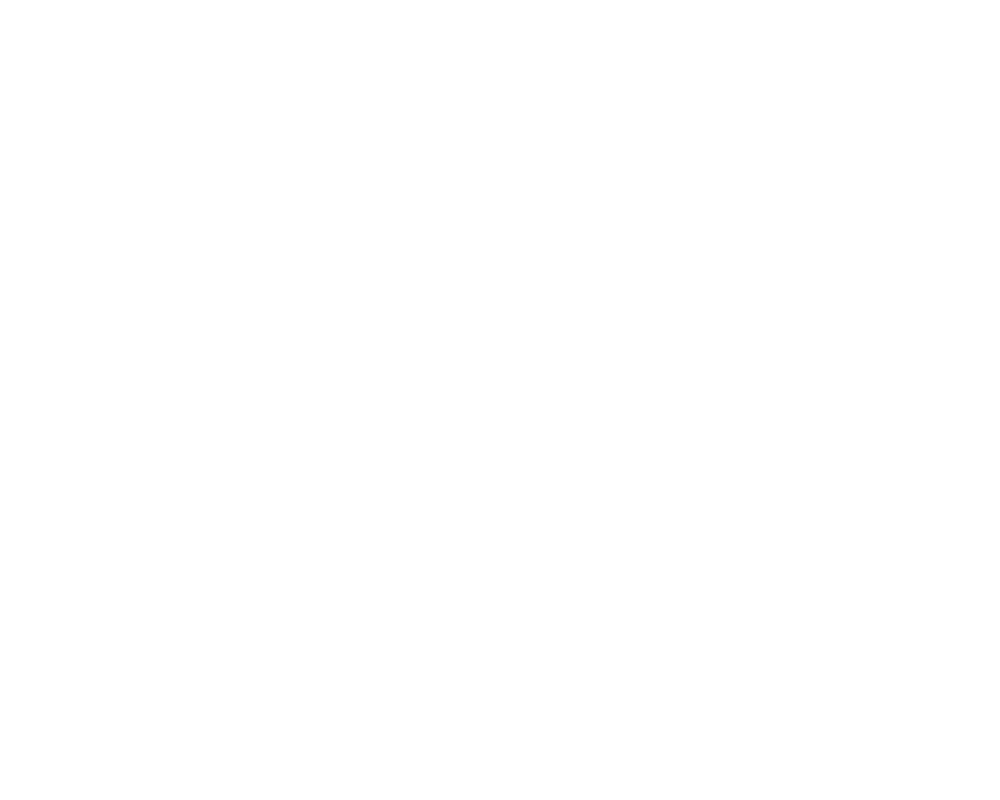

10
... [JC117|20191105|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


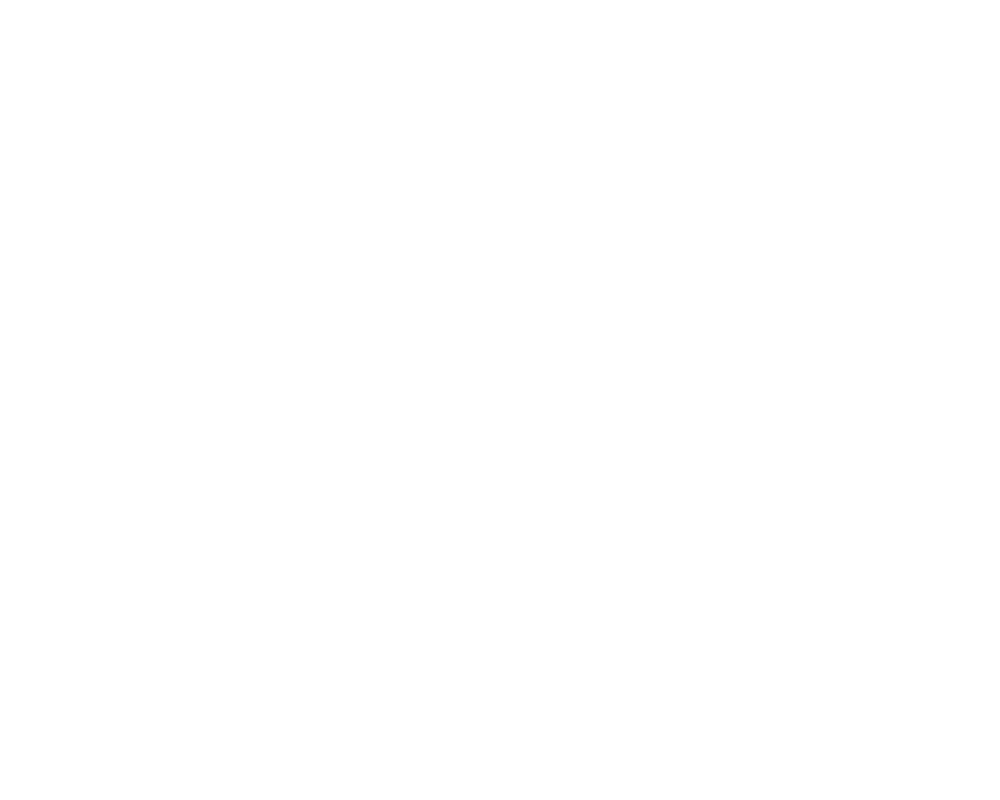

4


<IPython.core.display.Javascript object>


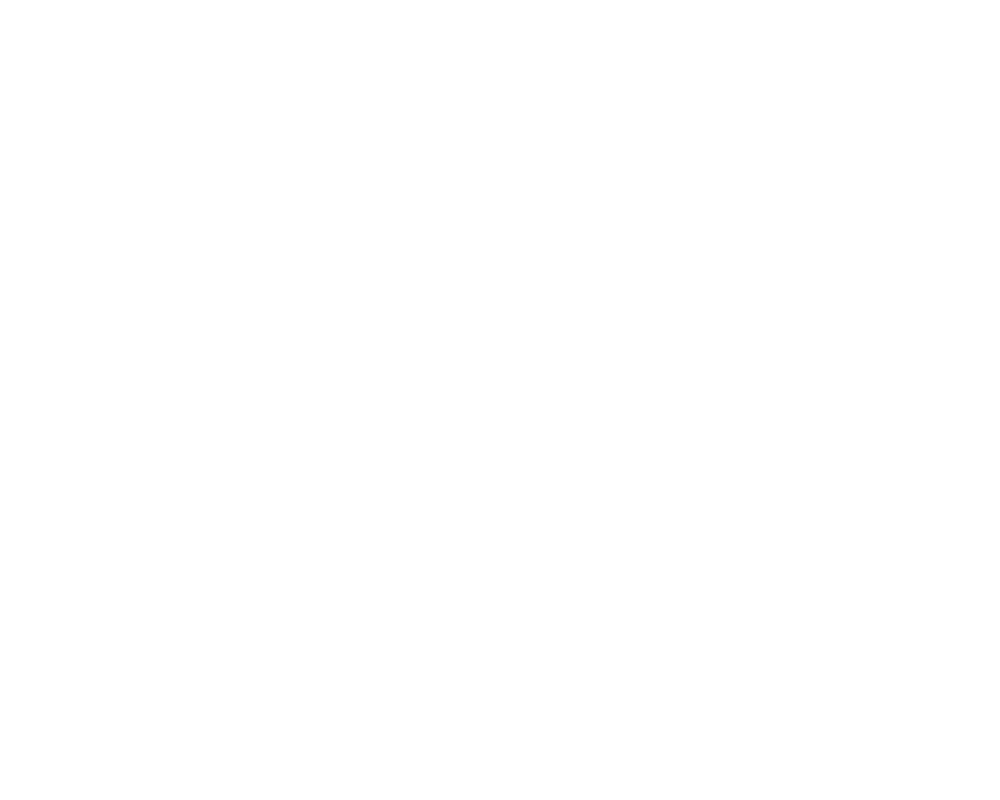

4
... [JC120|20191111|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


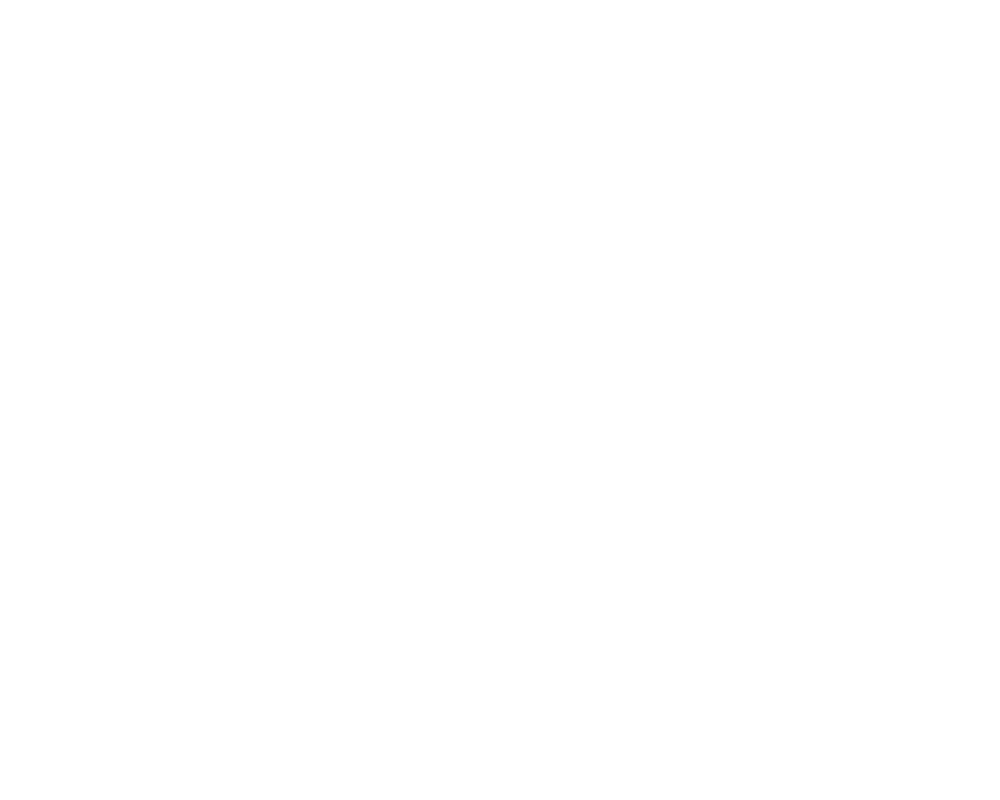

3


<IPython.core.display.Javascript object>


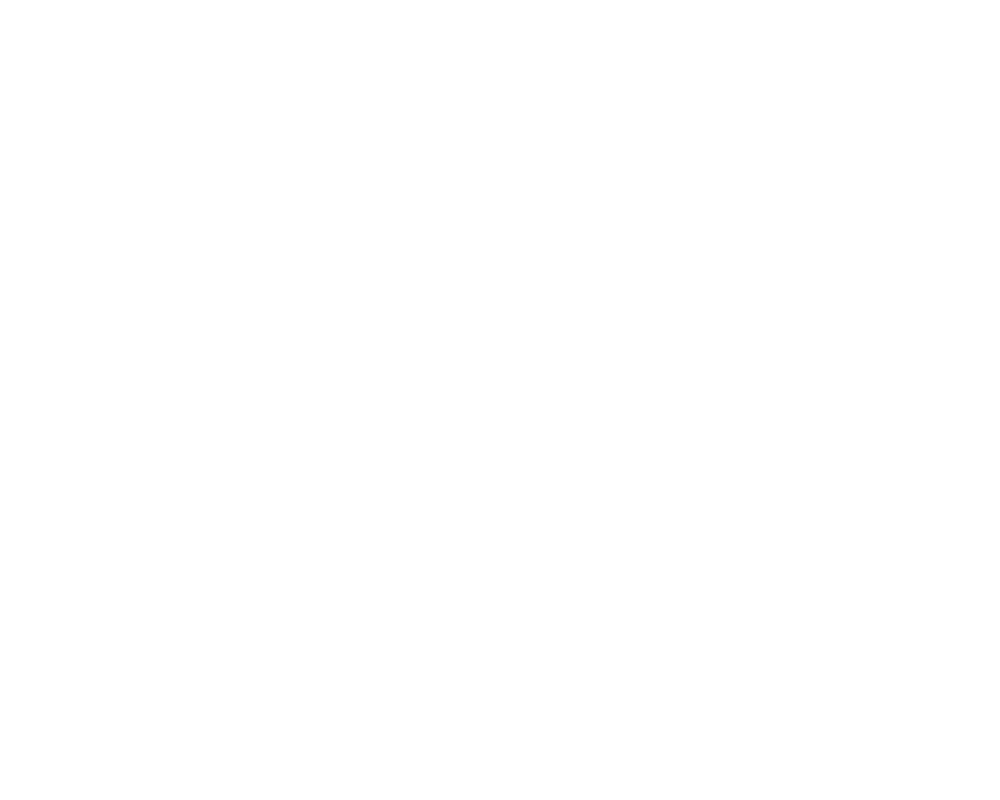

3
... [JC078|20190513|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


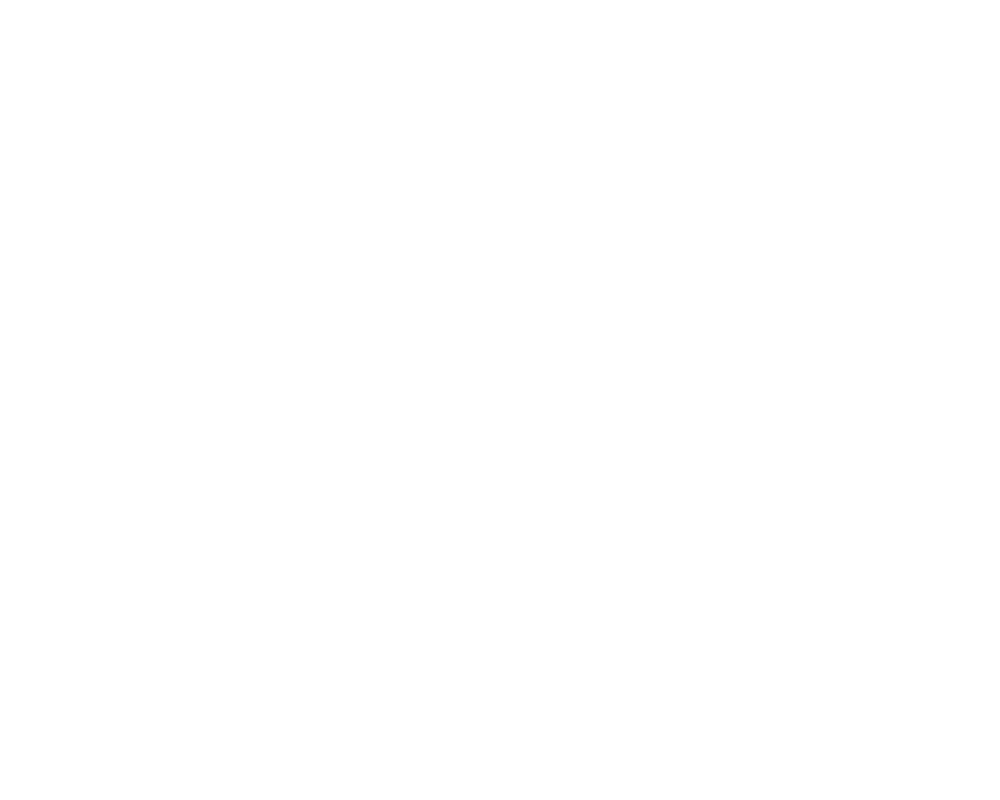

3


<IPython.core.display.Javascript object>


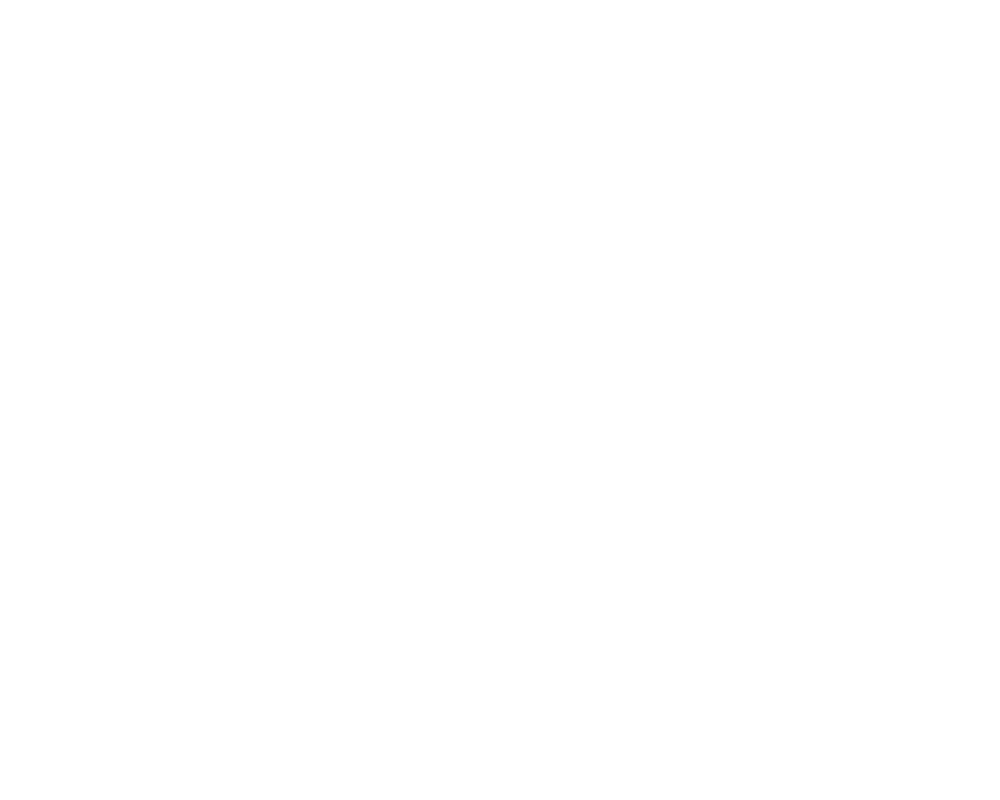

3
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


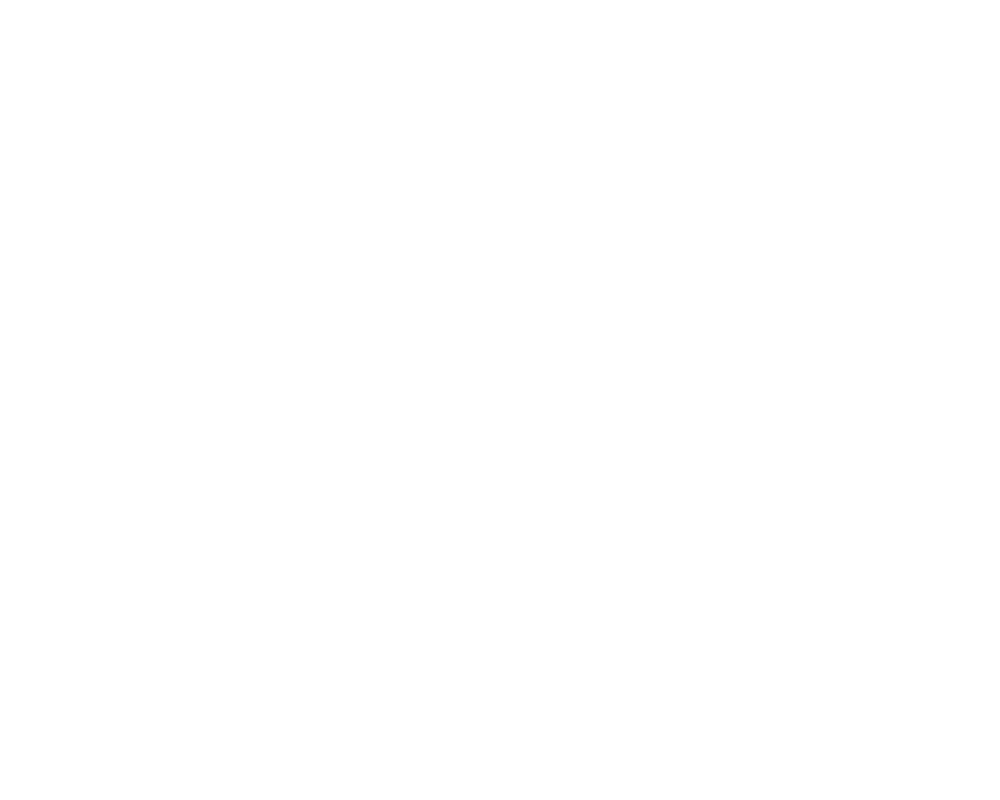

8


<IPython.core.display.Javascript object>


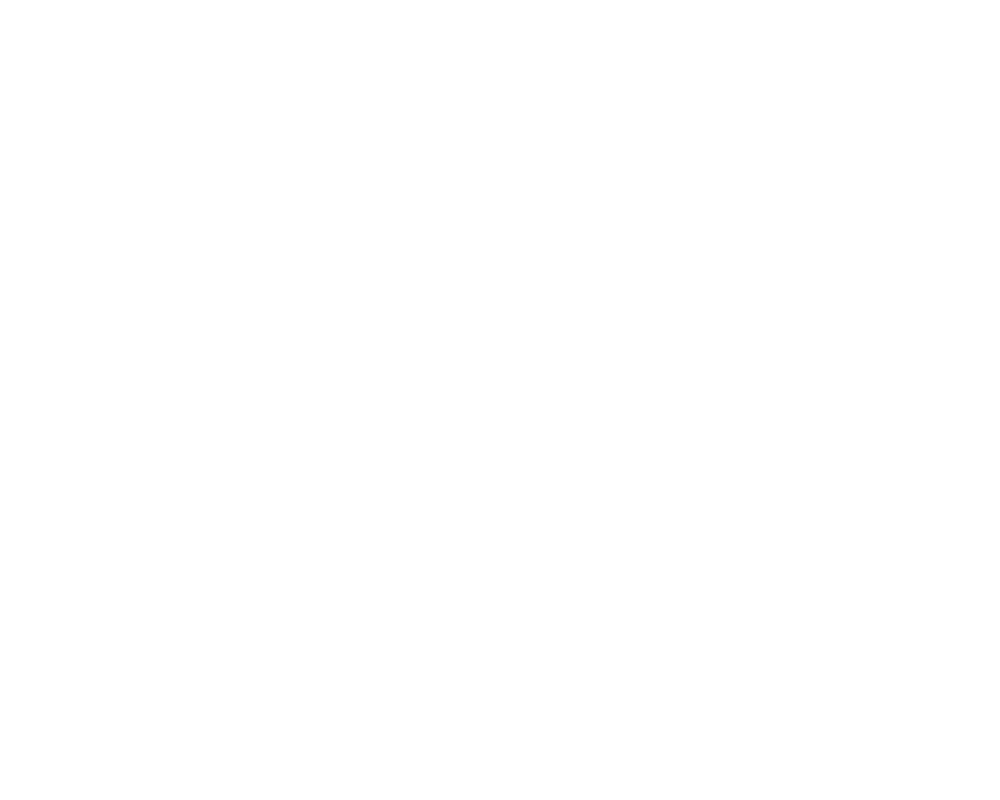

8
... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


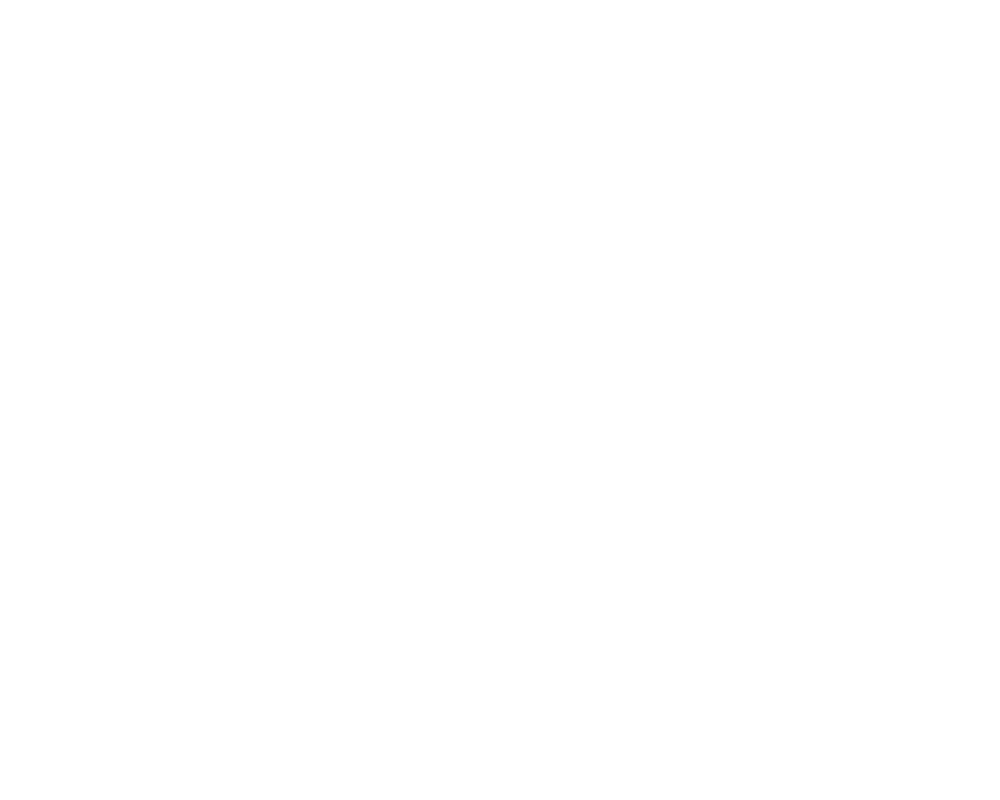

11


<IPython.core.display.Javascript object>


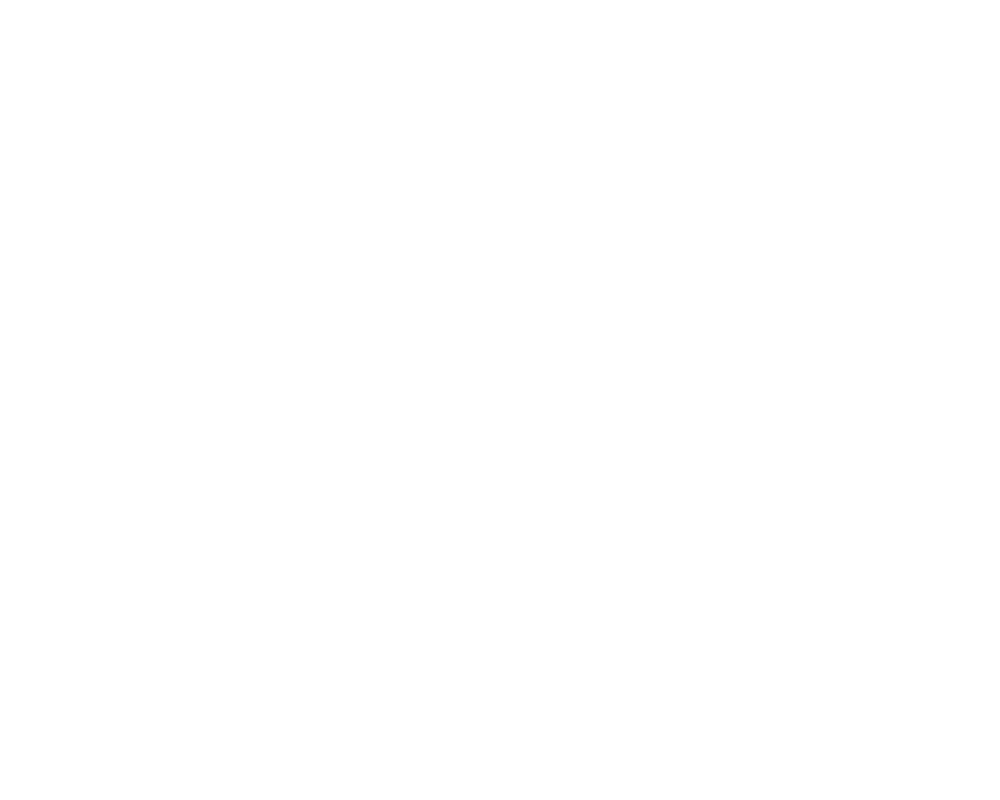

11
... [JC083|20190517|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


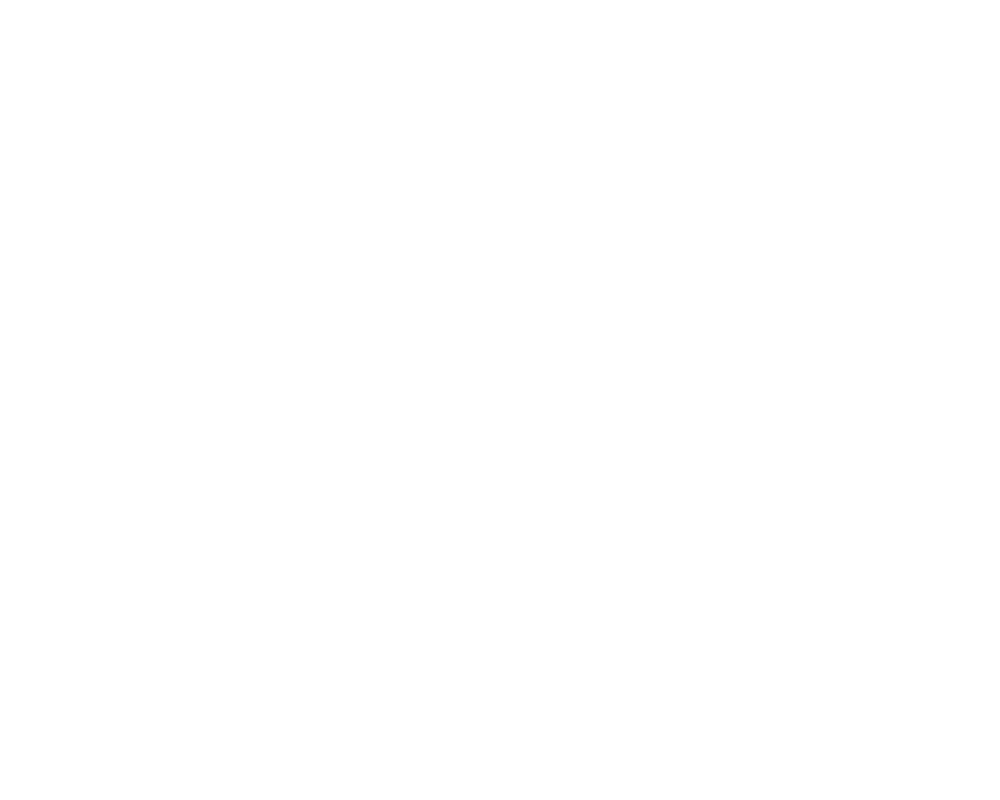

4


<IPython.core.display.Javascript object>


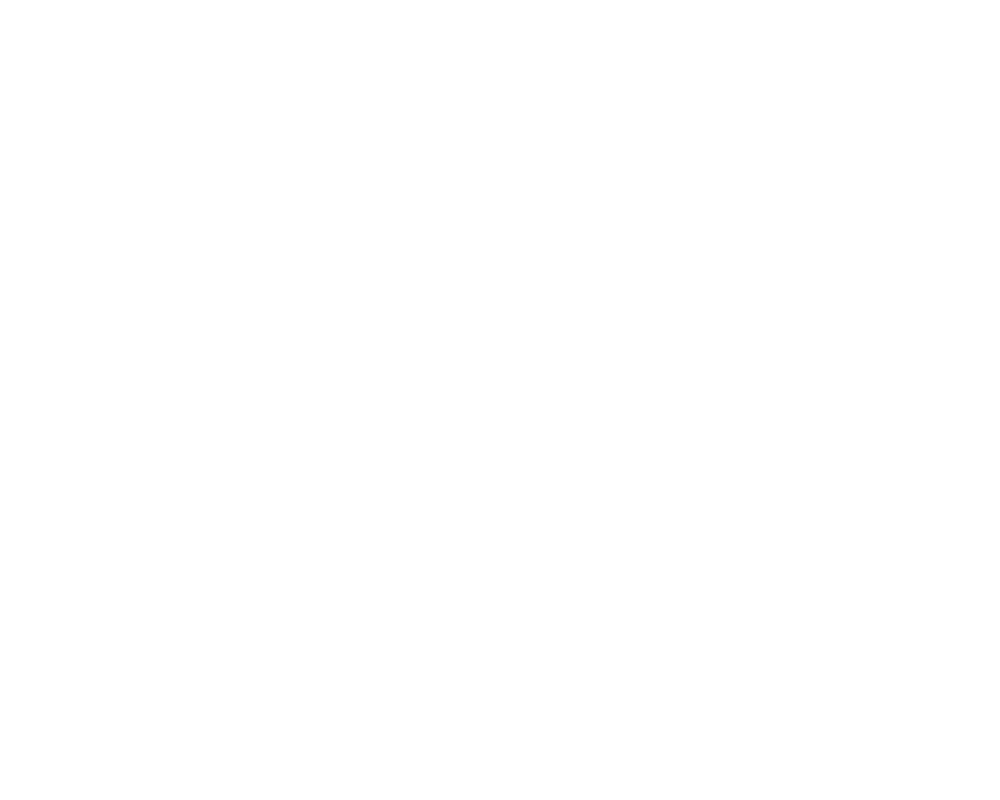

4
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


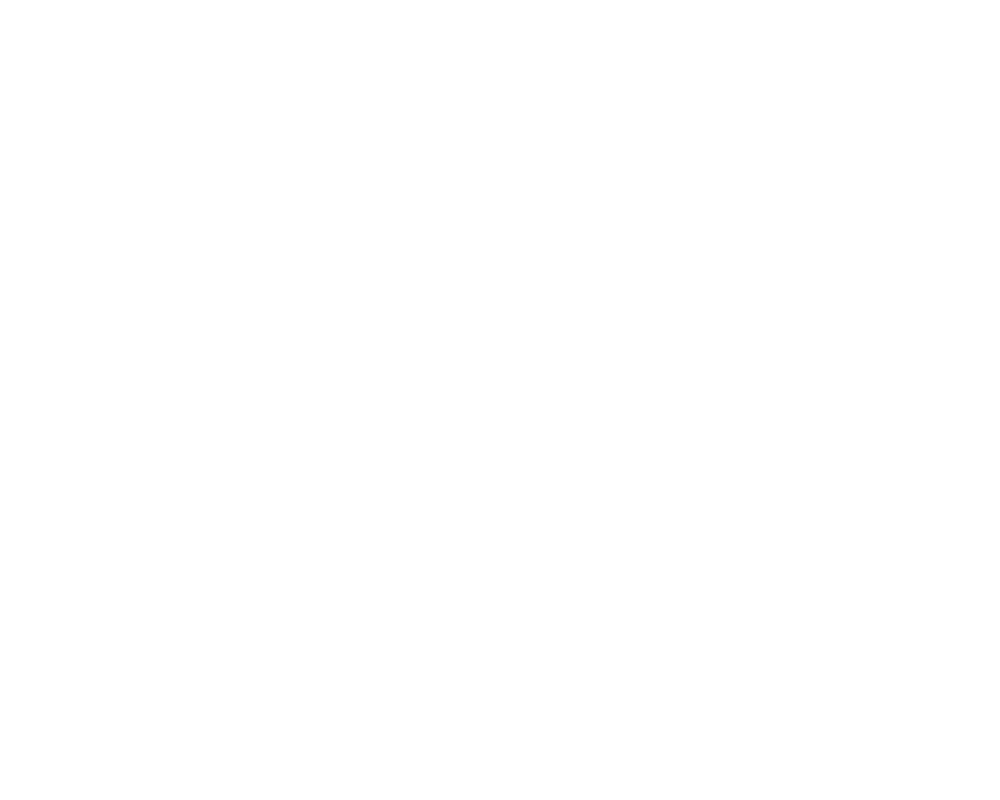

2


<IPython.core.display.Javascript object>


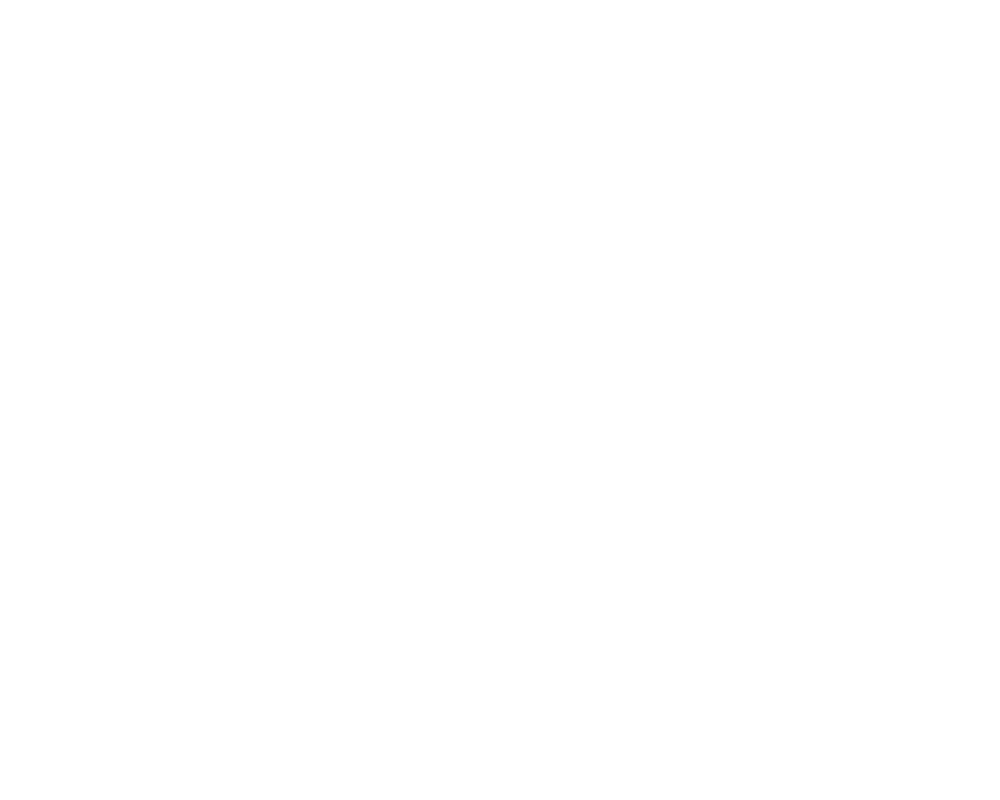

2
... [JC091|20190627|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


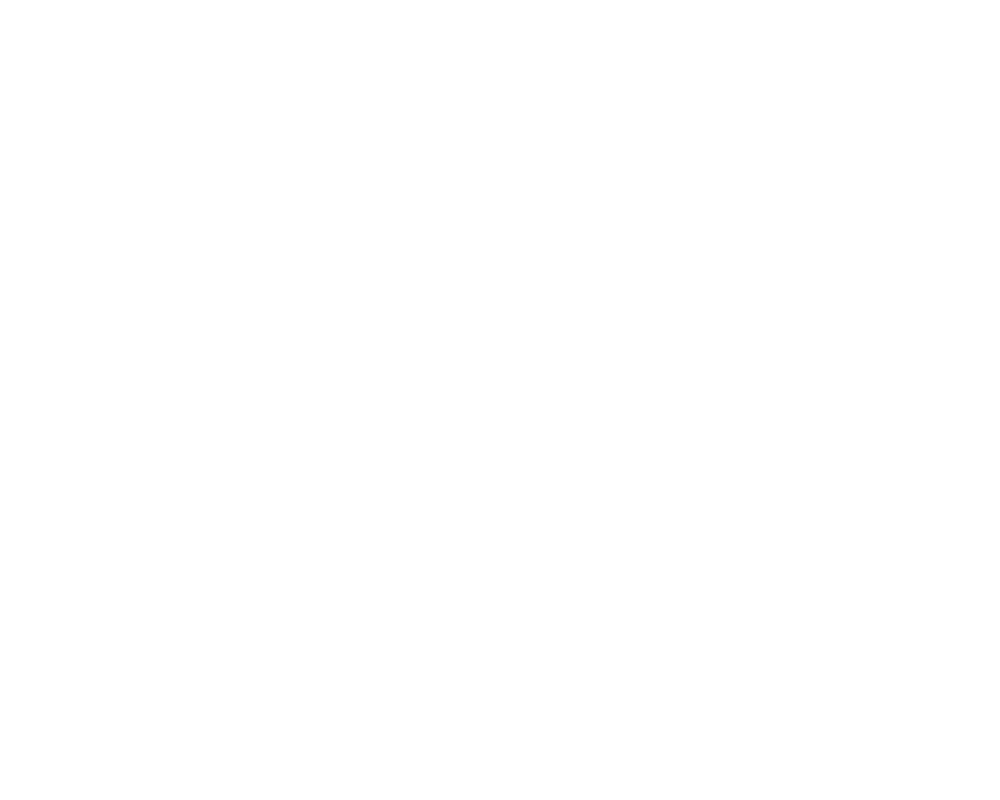

4


<IPython.core.display.Javascript object>


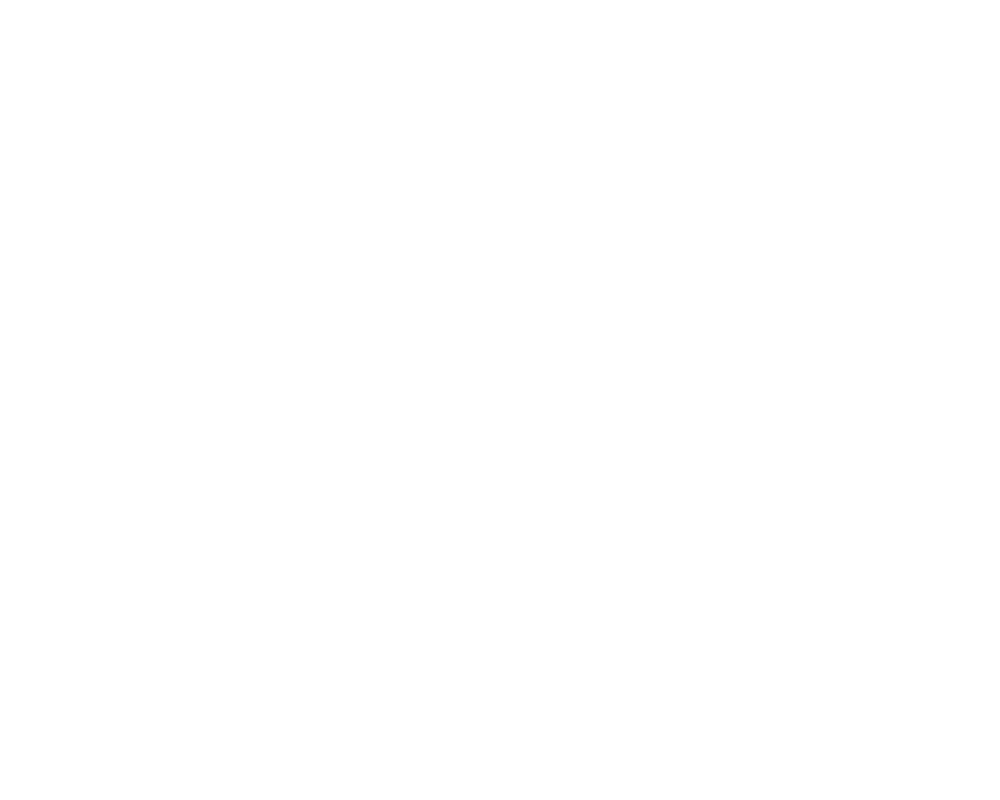

4
... [JC083|20190511|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


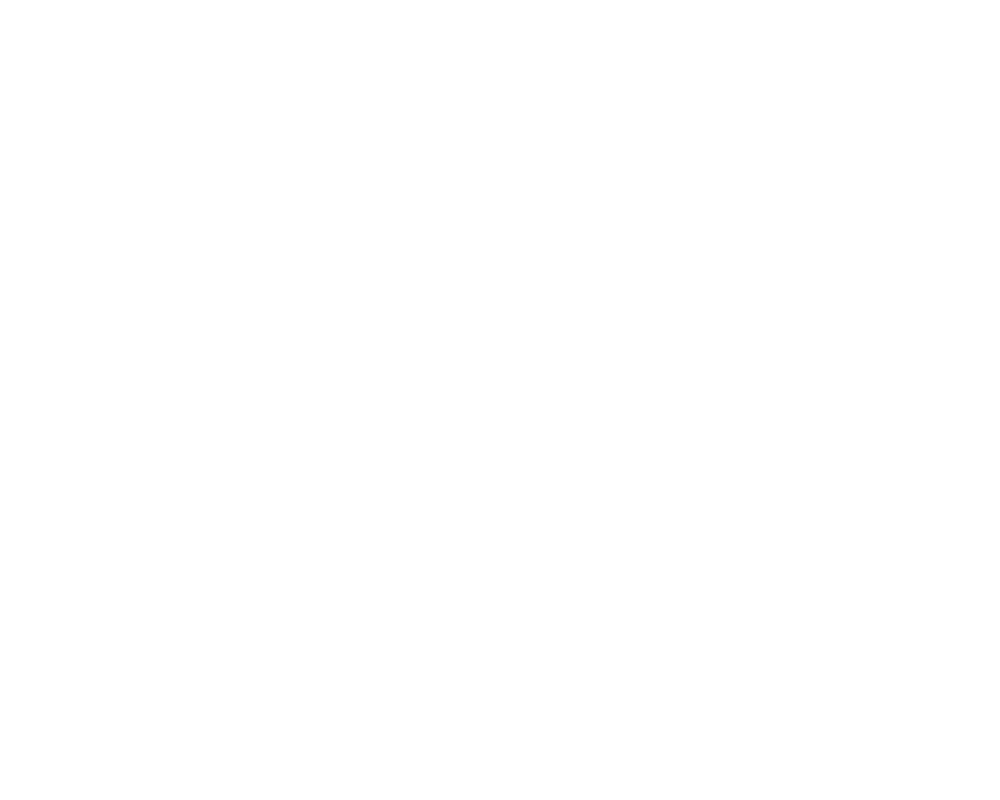

0


<IPython.core.display.Javascript object>


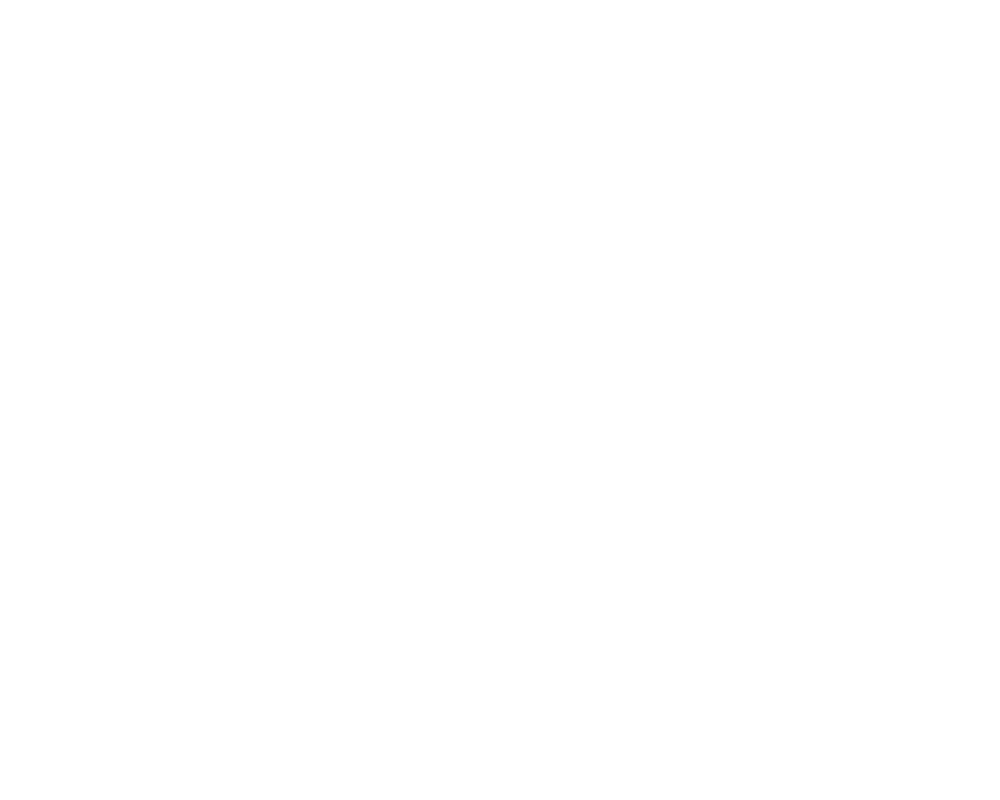

0
... [JC084|20190522|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


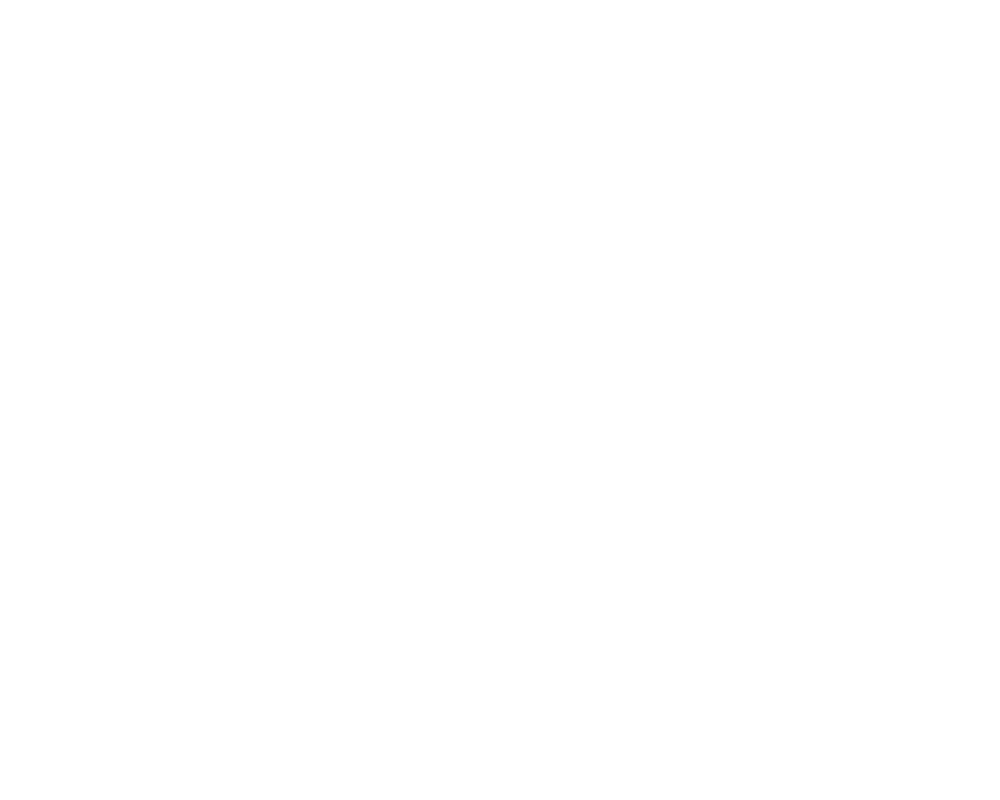

3


<IPython.core.display.Javascript object>


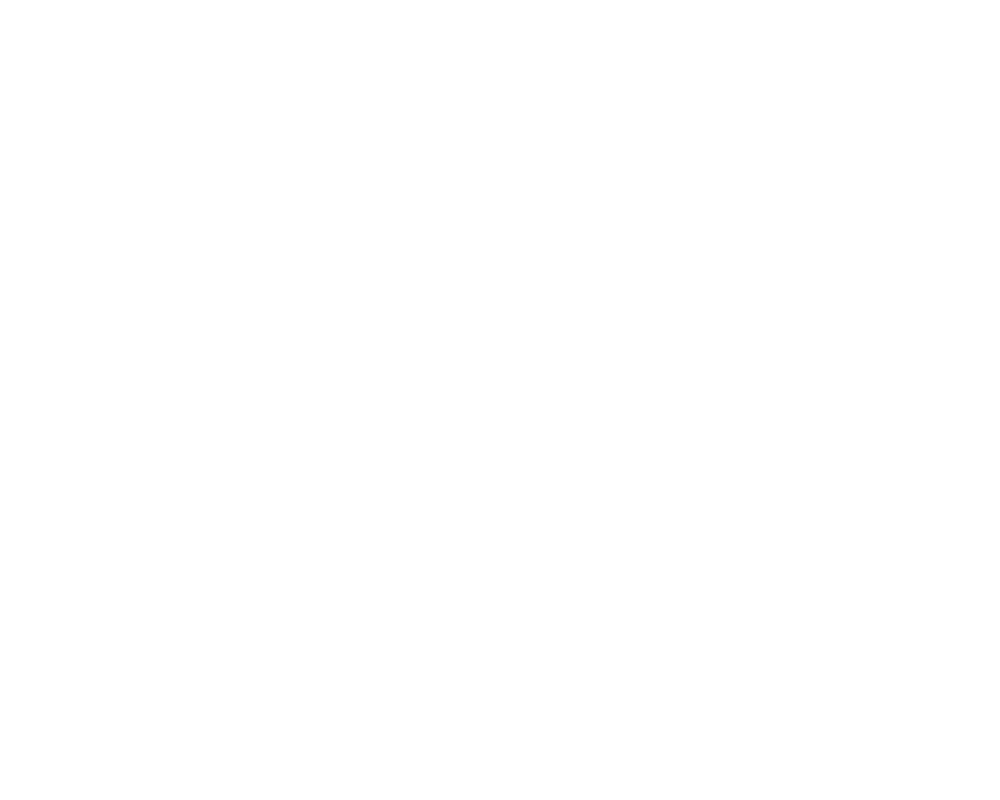

3
... [JC085|20190622|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


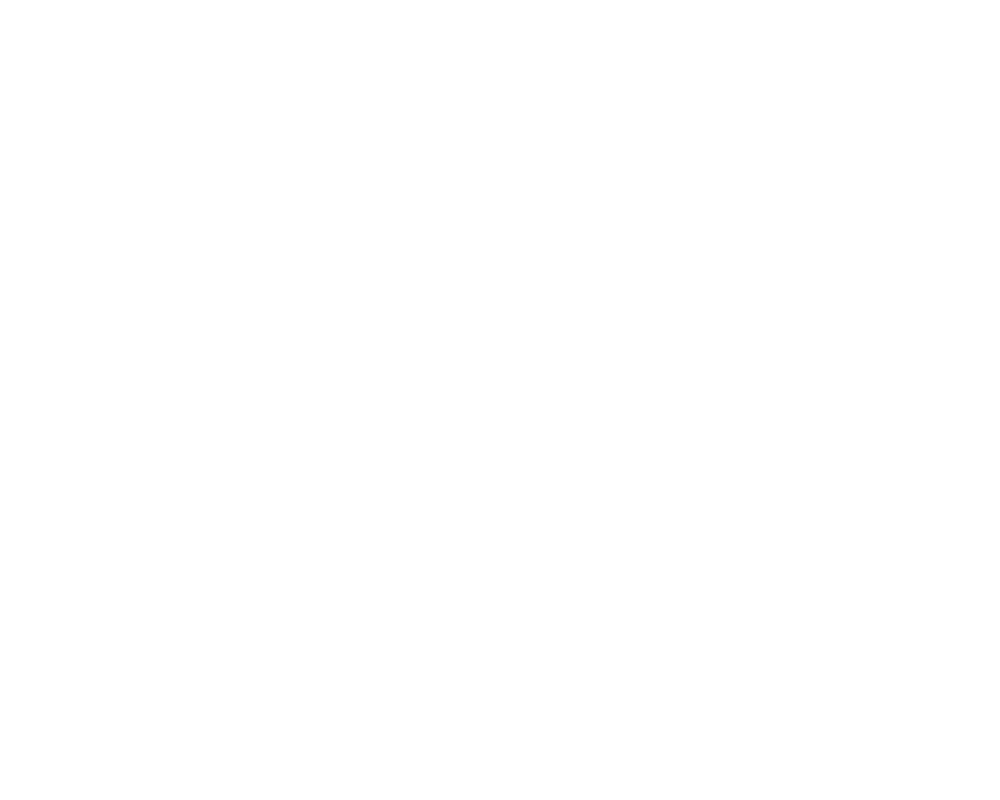

14


<IPython.core.display.Javascript object>


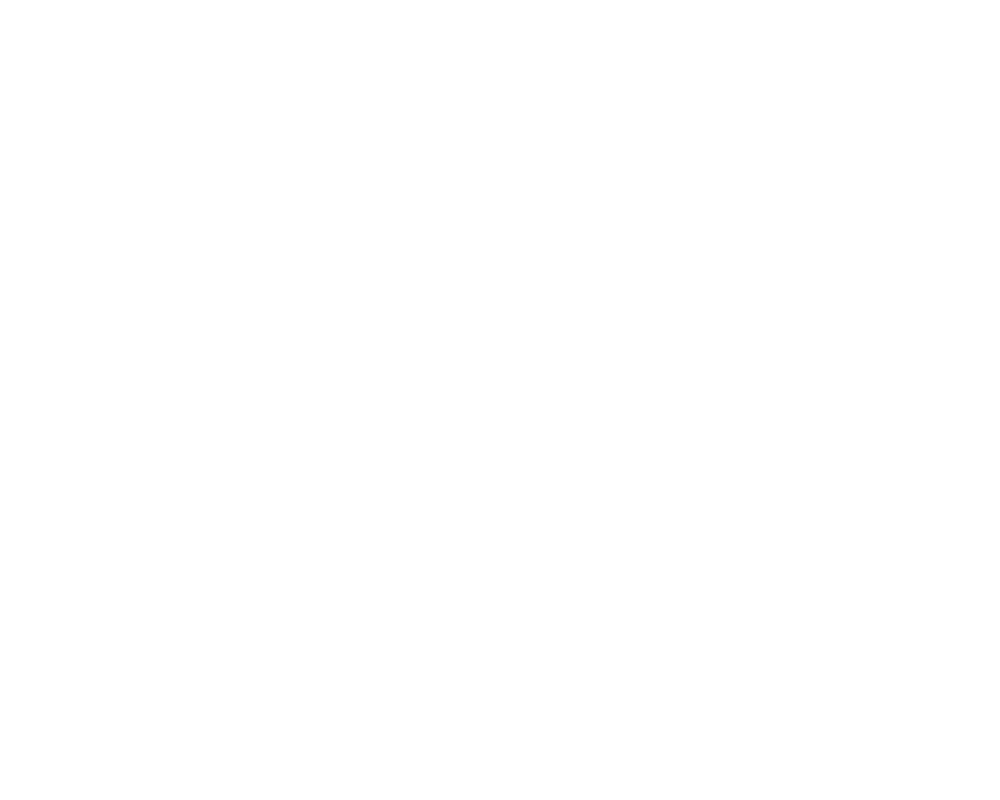

14
... [JC085|20190622|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


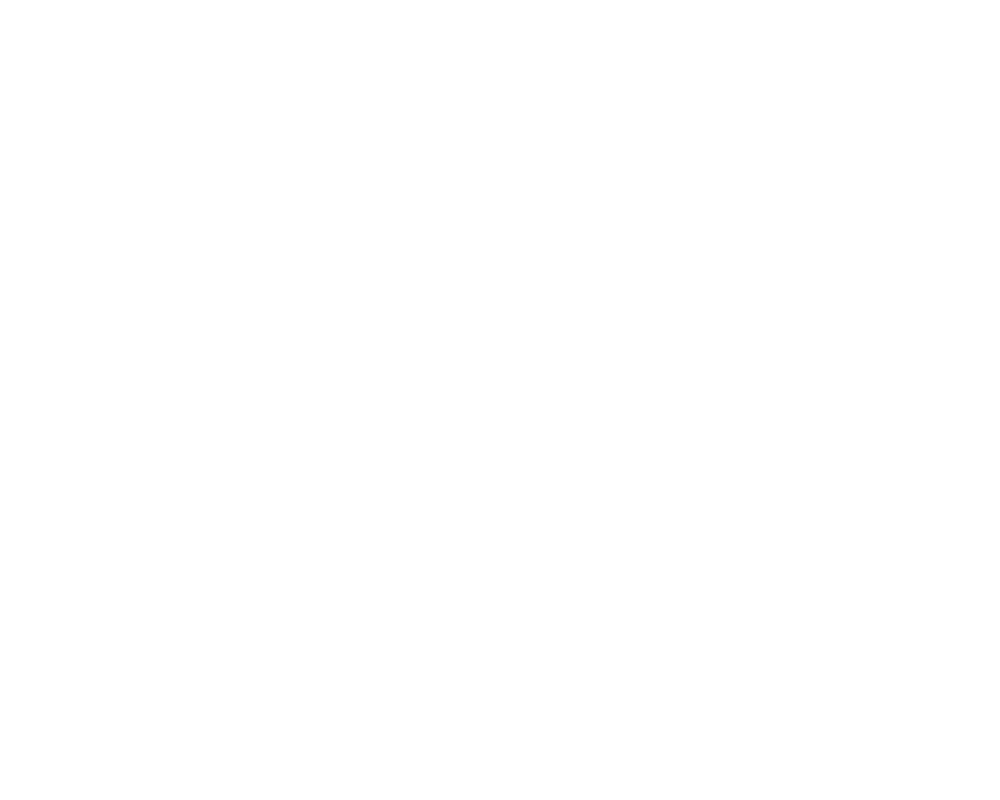

62


<IPython.core.display.Javascript object>


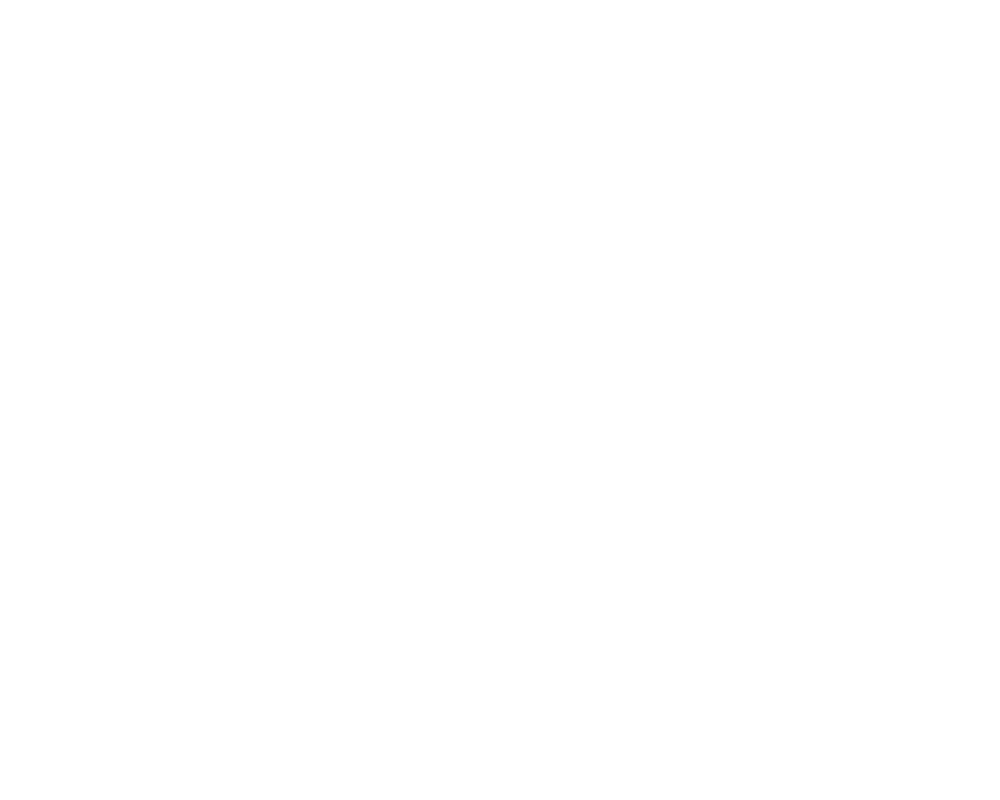

62
... [JC097|20190613|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


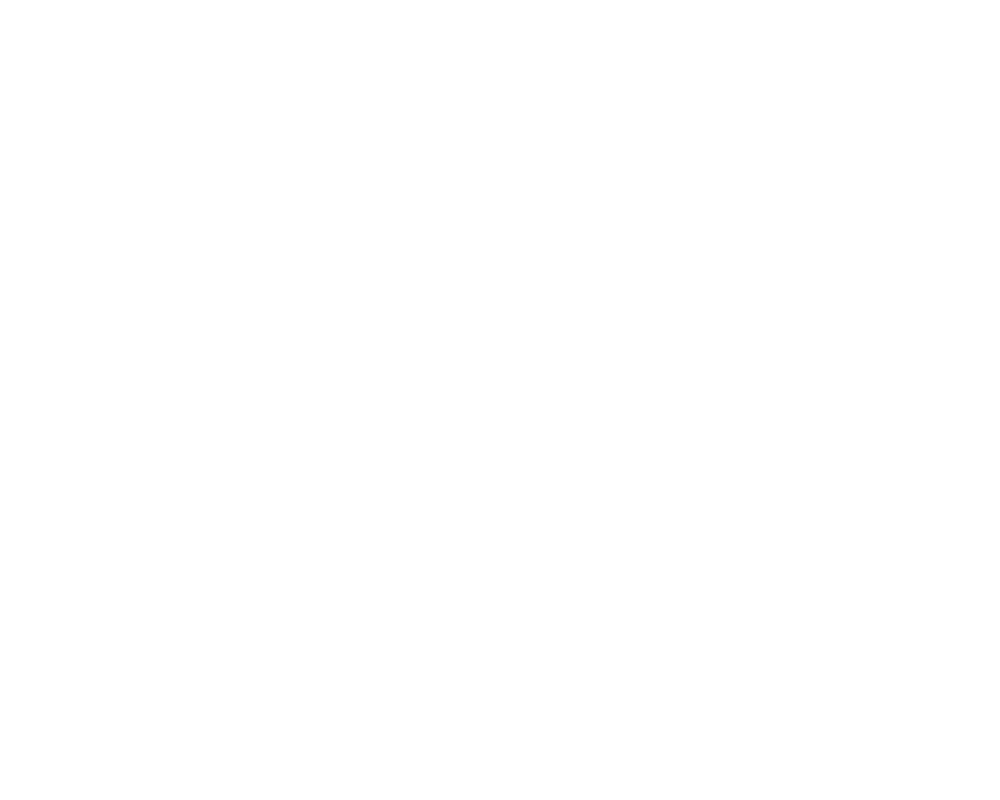

2


<IPython.core.display.Javascript object>


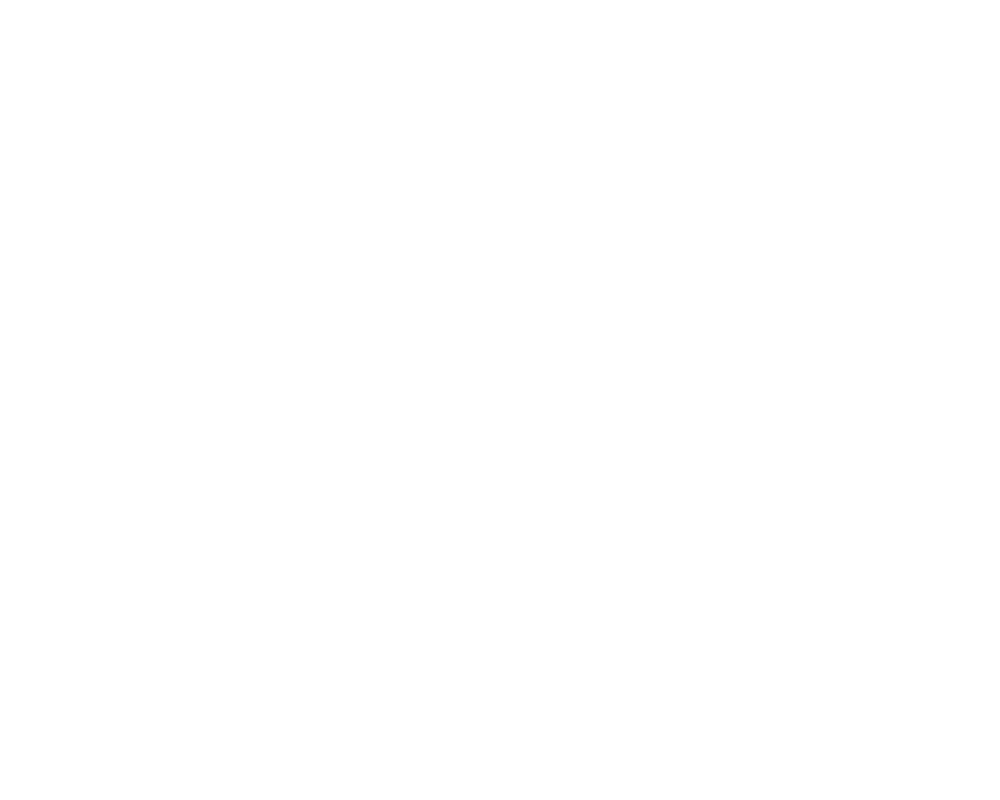

2
... [JC097|20190613|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


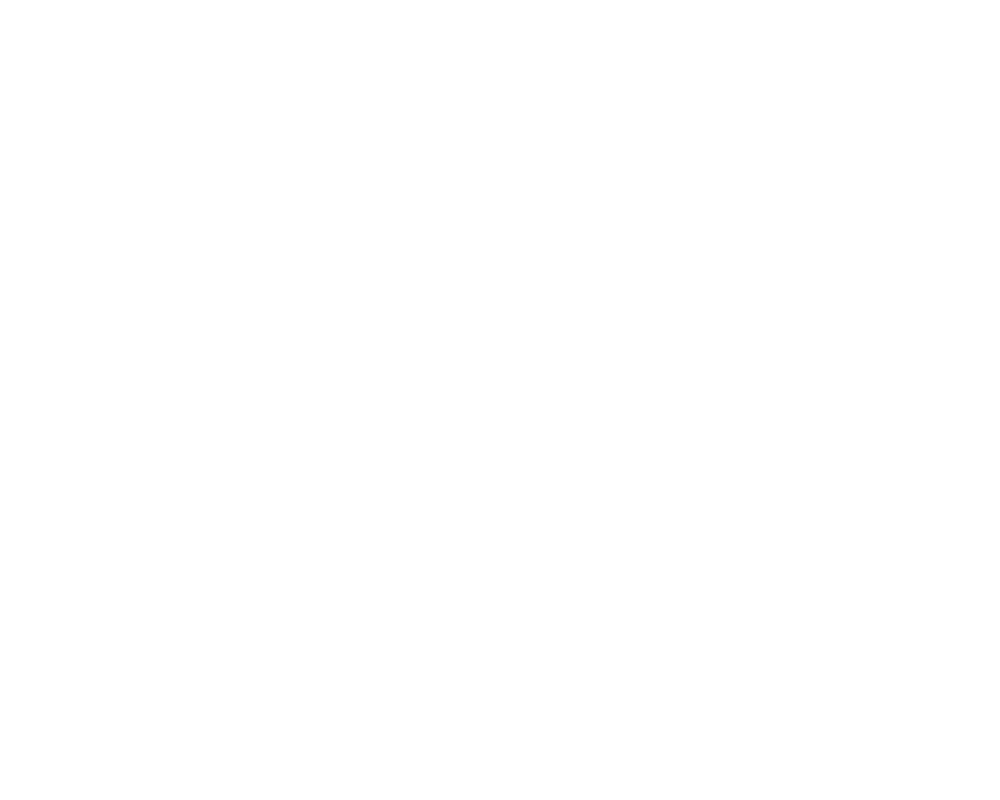

11


<IPython.core.display.Javascript object>


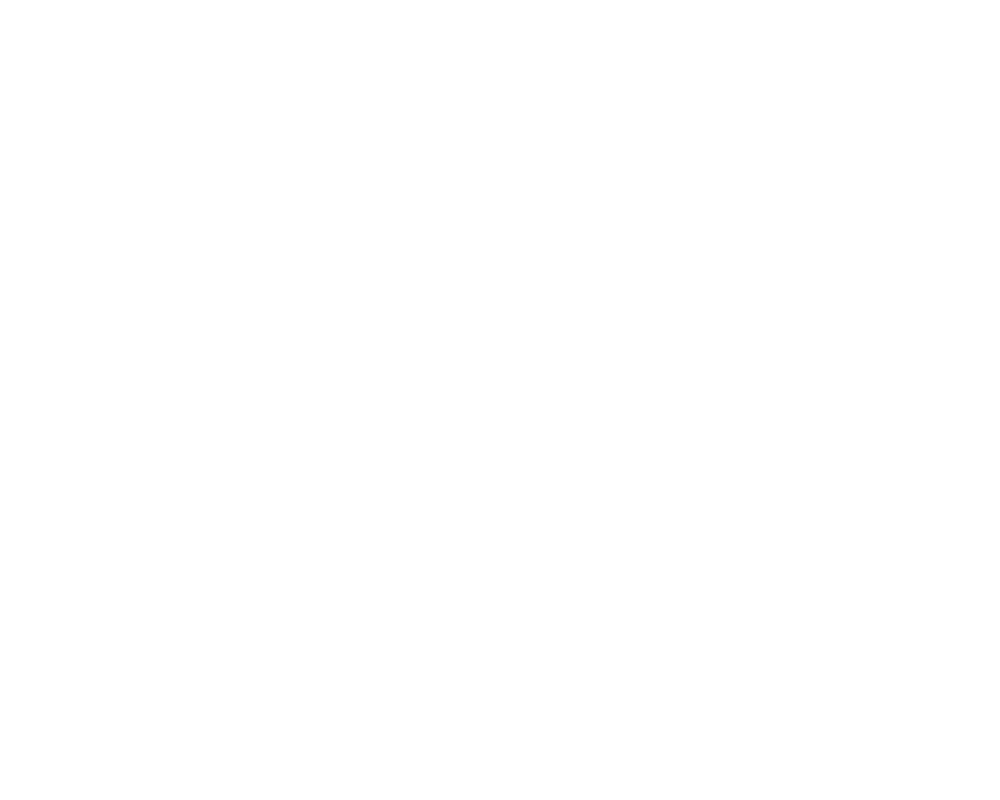

11
... [JC097|20190616|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


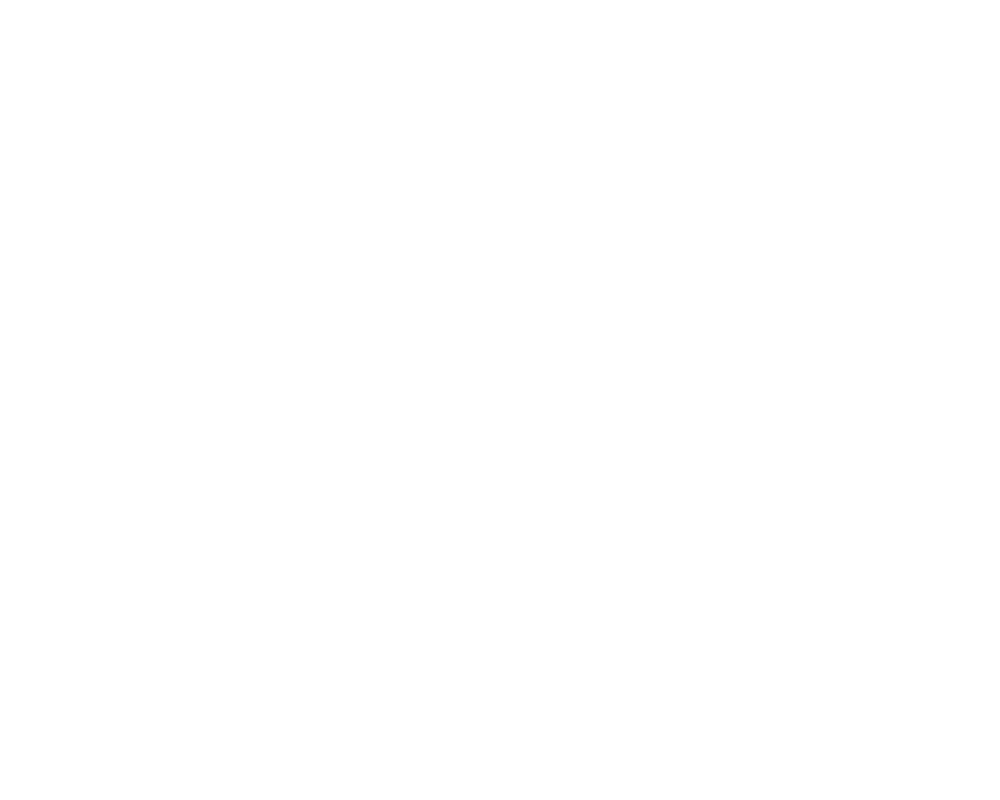

5


<IPython.core.display.Javascript object>


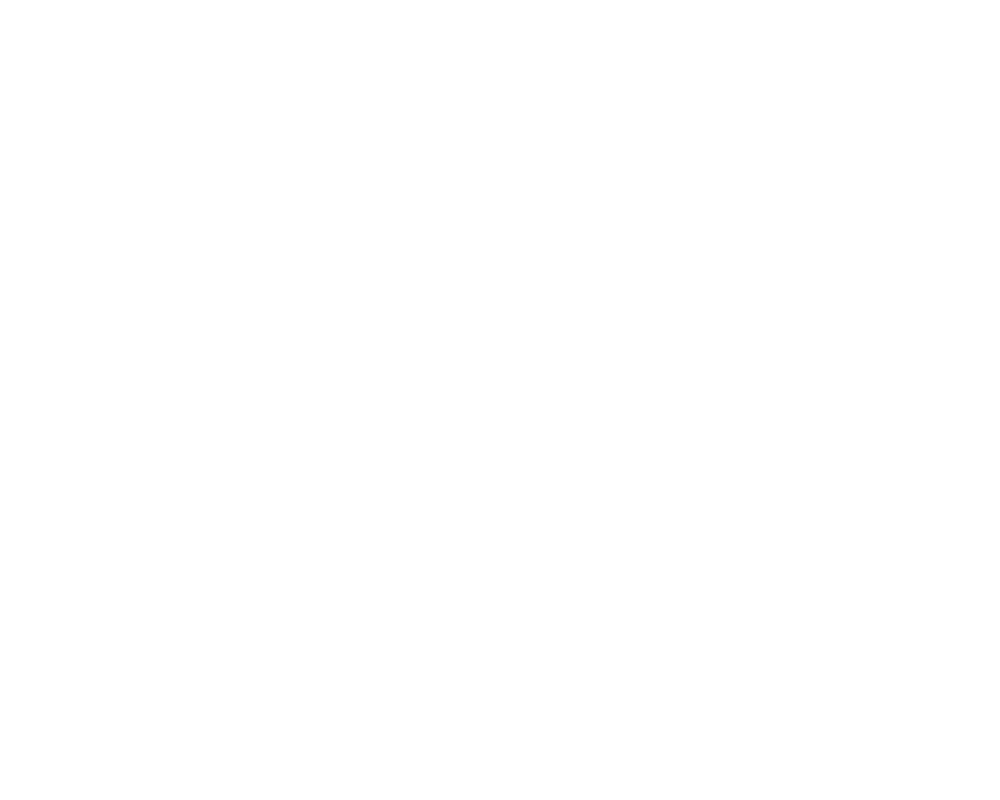

5
... [JC097|20190616|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


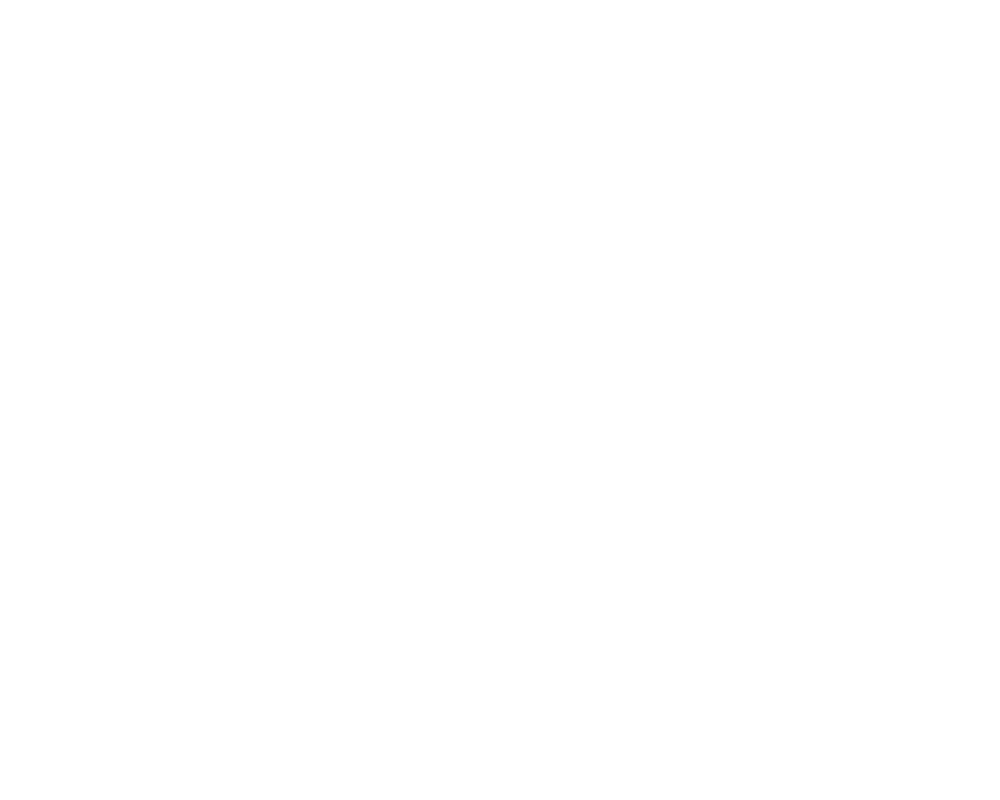

22


<IPython.core.display.Javascript object>


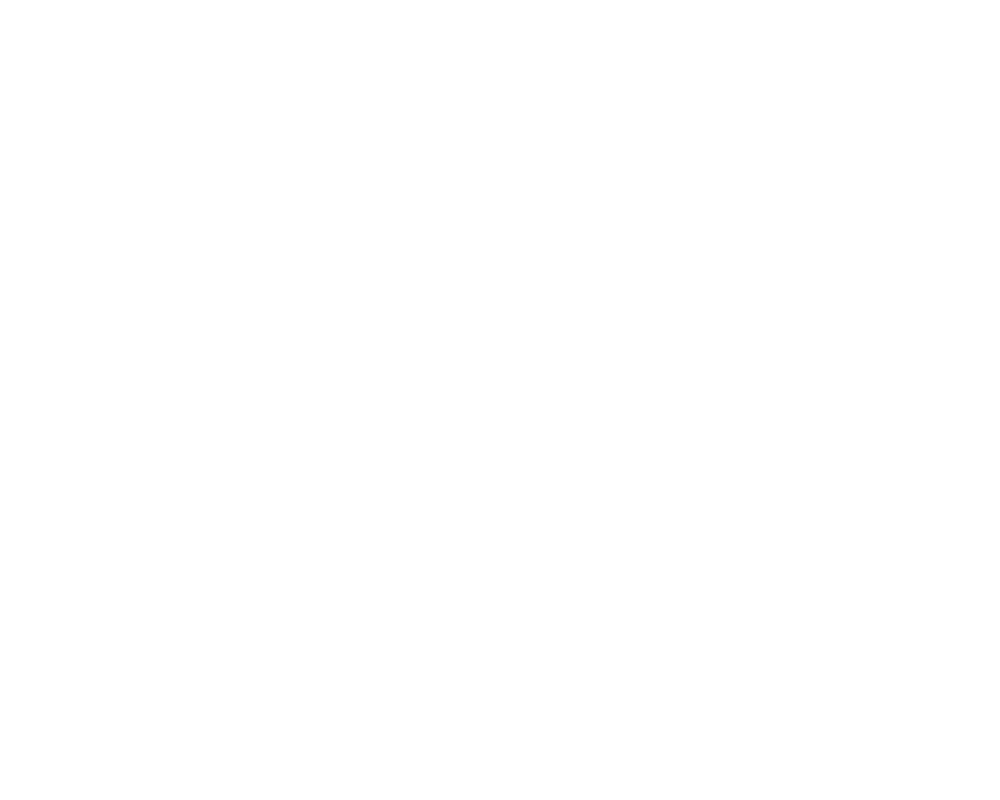

22
... [JC097|20190617|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


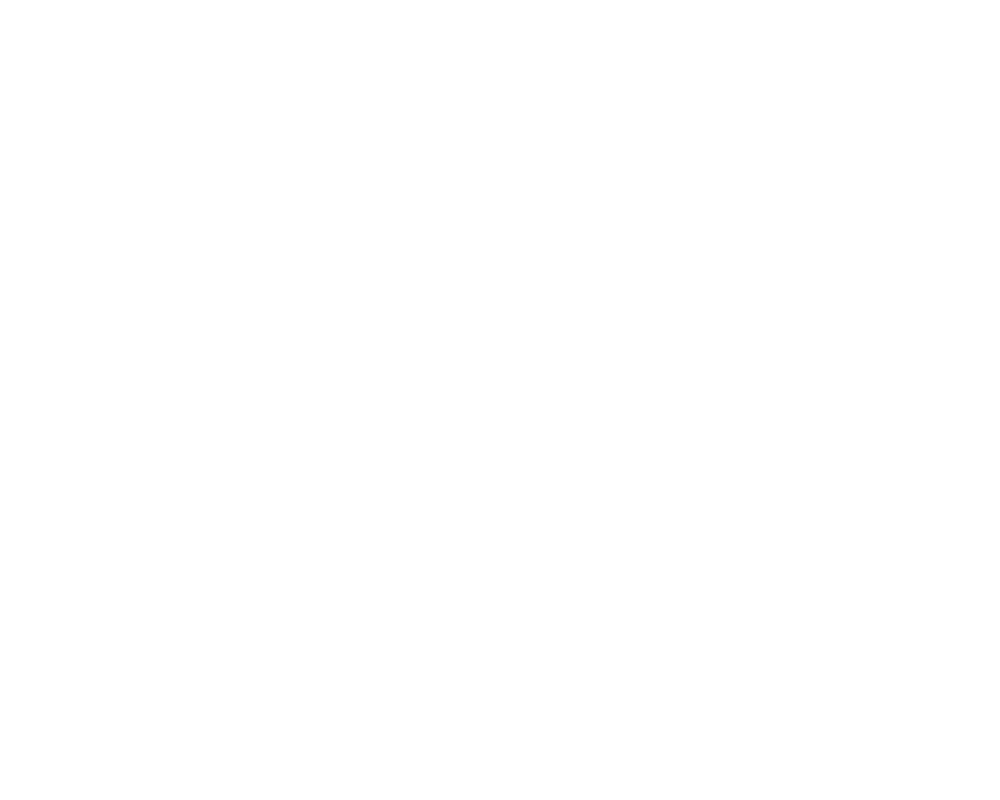

1


<IPython.core.display.Javascript object>


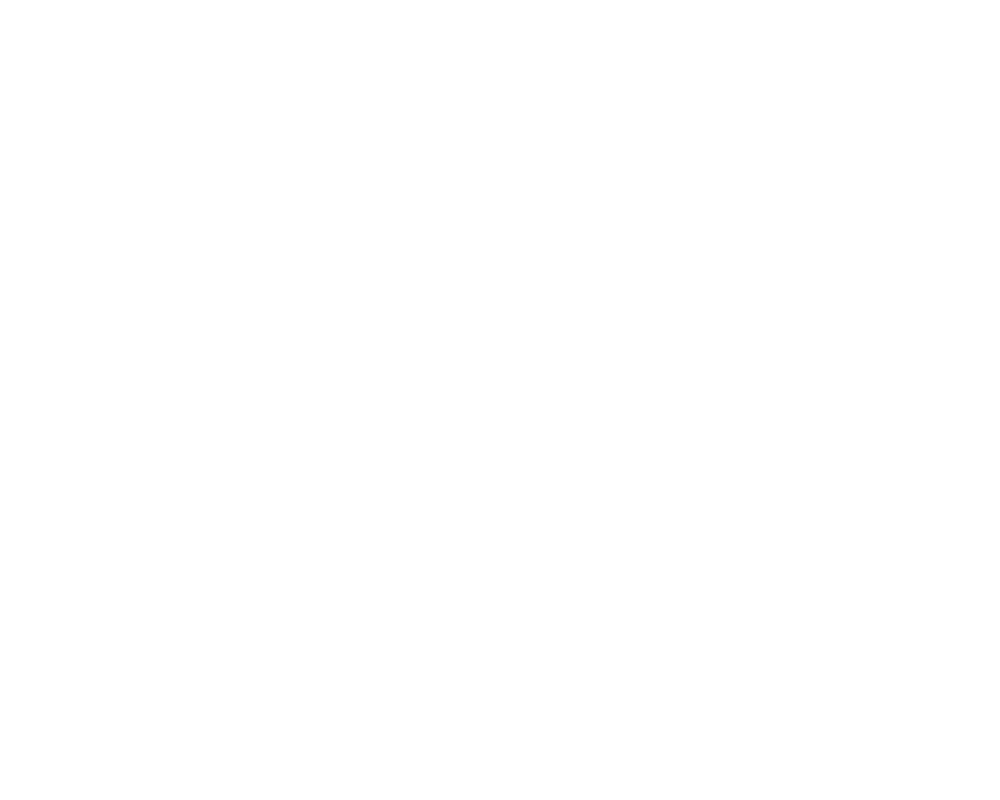

1
... [JC110|20191006|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
Saving stats output to: /n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


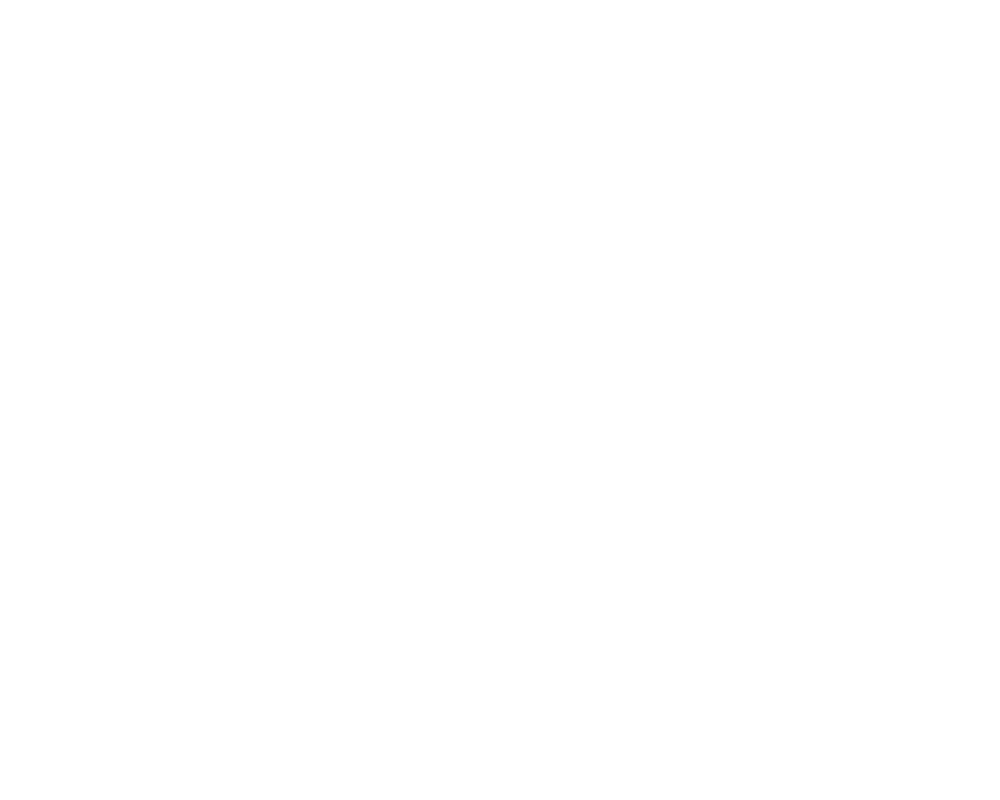

0


<IPython.core.display.Javascript object>


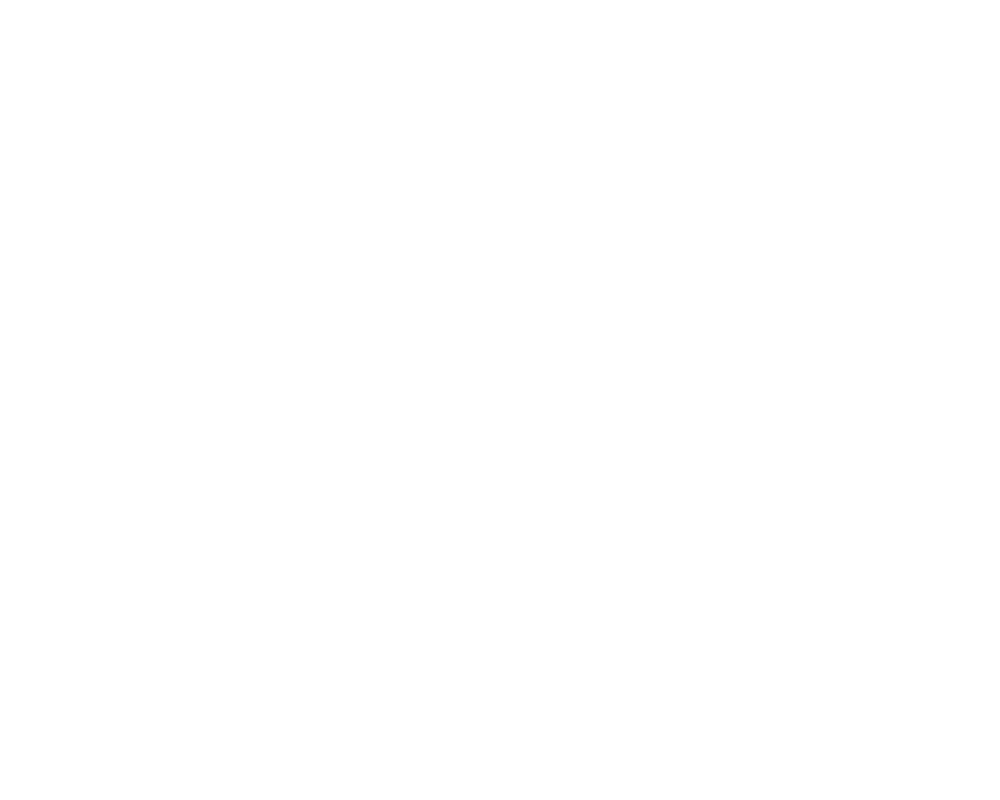

0
... [JC110|20191006|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
Saving stats output to: /n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/summaries/stats-traces001-corrected-dff-all
... loading existing stats
... loading existing evaluation results.


<IPython.core.display.Javascript object>


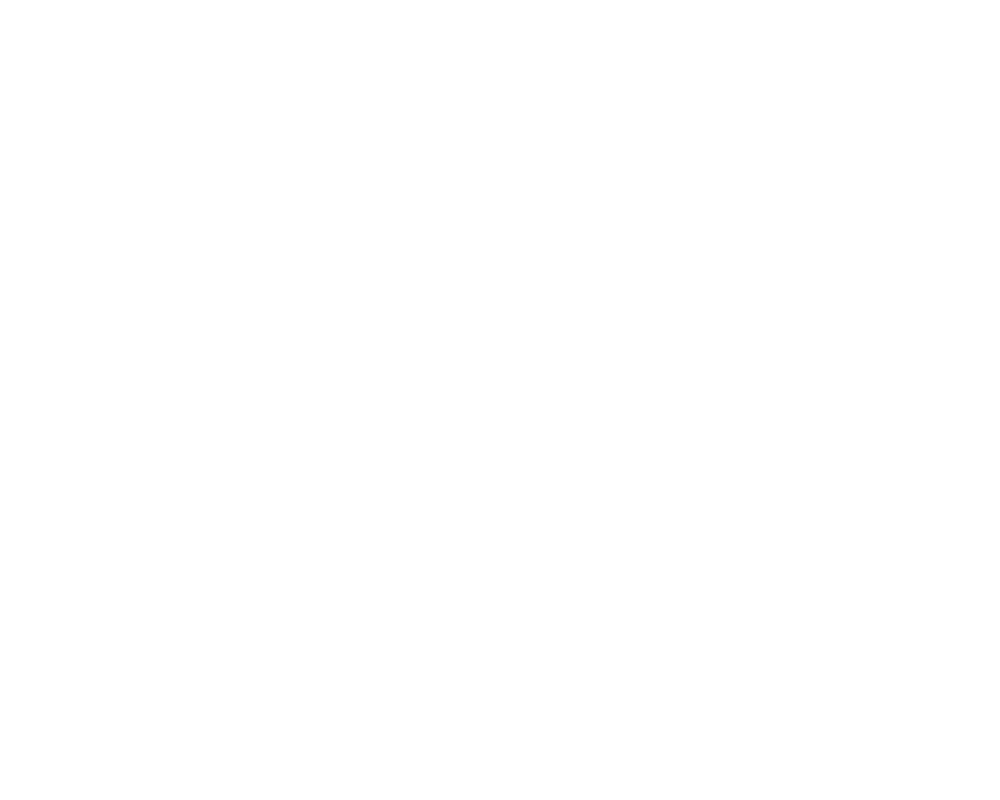

34


<IPython.core.display.Javascript object>


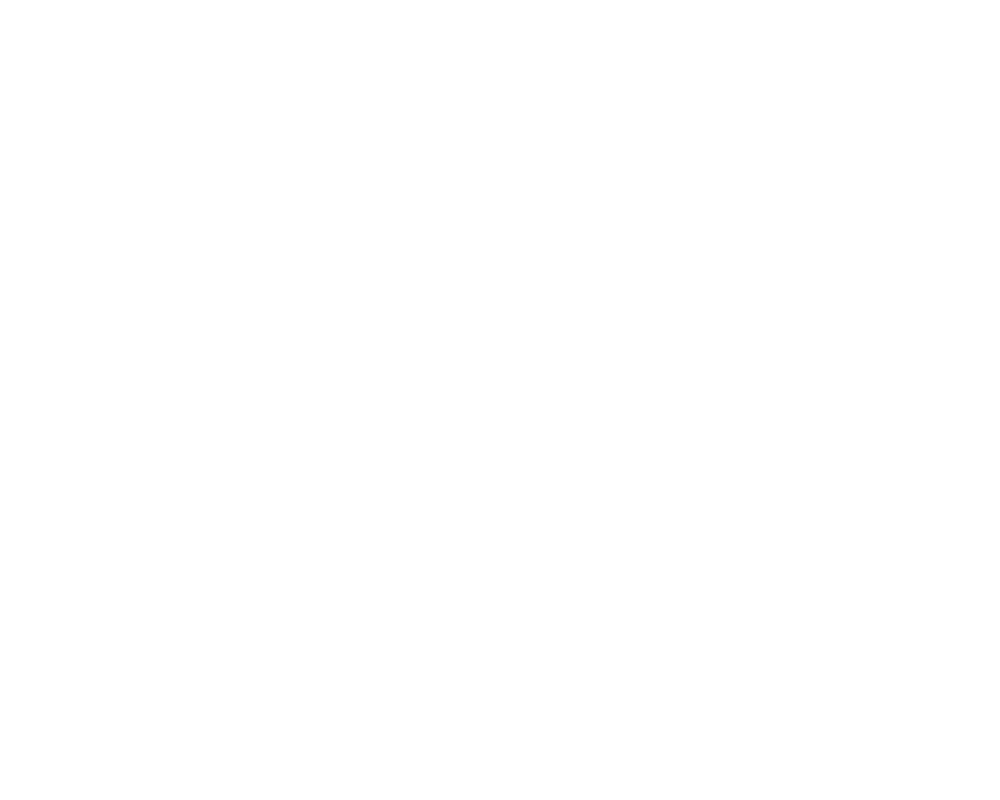

34


In [110]:
fit_thr = 0.05
sigma_scale=2.35
ci=0.95
n_iters = 1000
n_resamples = 10

devdf = []    
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if '%s-%s' % (animalid, session) in excluded_sessions:
        continue
        
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    fov = 'FOV%i_zoom2p0x' % fovnum
    
    rfnames = [r for r in g['experiment'].values if 'rf' in r]
    for rfname in rfnames:
        exp = util.ReceptiveFields(rfname, animalid, session, fov,
                                   traceid=traceid) #, trace_type='dff')
        statsdir, stats_desc = util.create_stats_dir(exp.animalid, exp.session, exp.fov,
                                                      traceid=exp.traceid, trace_type=exp.trace_type,
                                                      response_type=response_type, 
                                                      responsive_test=None, responsive_thr=0)

        if not os.path.exists(os.path.join(statsdir, 'receptive_fields')):
            os.makedirs(os.path.join(statsdir, 'receptive_fields'))
        print("Saving stats output to: %s" % statsdir)    


        #%%
        # Get output dir for stats
        estats = exp.get_stats(response_type=response_type, fit_thr=fit_thr) # estats.rois = list of all cells that pass fit-thr
        rfdf = estats.fits
        fovinfo = estats.fovinfo
        rois_rfs = rfdf.index.tolist()

        # Get RF dir for current fit type         
        rfdir, fit_desc = fitrf.create_rf_dir(exp.animalid, exp.session, exp.fov, exp.name, traceid=exp.traceid,
                                        response_type=response_type, fit_thr=fit_thr)

        data_identifier = '|'.join([animalid, session, fov, traceid, exp.rois, exp.trace_type, fit_desc])

        # Get bootstrap results for evaluated RFs
        bootresults = evalrfs.evaluate_rfs(estats, rfdir=rfdir, 
                                           n_bootstrap_iters=n_iters, n_resamples=n_resamples,
                                           ci=ci, sigma_scale=sigma_scale)

        regresults = evalrfs.compare_regr_to_boot_params(bootresults, fovinfo, statsdir=statsdir, data_identifier=data_identifier)

        # Identify good fits and deviants
        bad_either = np.union1d(regresults['azimuth']['bad_fits'], regresults['elevation']['bad_fits'])
        pass_rois_rfs = np.array([r for r in rois_rfs if r not in bad_either])
        deviants_either = np.union1d(regresults['azimuth']['deviants'], regresults['elevation']['deviants'])
        deviant_rois = np.intersect1d(pass_rois_rfs, deviants_either)
        #print(len(deviant_rois), len(pass_rois_rfs), len(rois_rfs), len(bad_either))

        for cond in regresults.keys():
            nsamples = len(regresults[cond]['deviants'])
            devdf.append(pd.DataFrame({'cond': [cond for _ in np.arange(0, nsamples)],
                          'deviants': regresults[cond]['deviants'],
                          'nrois': [len(pass_rois_rfs) for _ in np.arange(0, nsamples)],
                          'visual_area': [visual_area for _ in np.arange(0, nsamples)],
                         'rfname': [rfname for _ in np.arange(0, nsamples)],
                          'datakey': [datakey for _ in np.arange(0, nsamples)]}))


In [111]:
devdf = pd.concat(devdf, axis=0)


In [112]:
devdf[devdf['visual_area']=='V1']


,cond,datakey,deviants,nrois,rfname,visual_area
0,elevation,20190511_JC083_fov1,11.0,48.0,rfs,V1
1,elevation,20190511_JC083_fov1,26.0,48.0,rfs,V1
2,elevation,20190511_JC083_fov1,31.0,48.0,rfs,V1
3,elevation,20190511_JC083_fov1,32.0,48.0,rfs,V1
4,elevation,20190511_JC083_fov1,33.0,48.0,rfs,V1
5,elevation,20190511_JC083_fov1,39.0,48.0,rfs,V1
6,elevation,20190511_JC083_fov1,65.0,48.0,rfs,V1
7,elevation,20190511_JC083_fov1,92.0,48.0,rfs,V1
8,elevation,20190511_JC083_fov1,96.0,48.0,rfs,V1
9,elevation,20190511_JC083_fov1,125.0,48.0,rfs,V1


In [113]:
i=0
fraction_dev=[]
for (v, dk), g in devdf[devdf['cond']=='azimuth'].groupby(['visual_area', 'datakey']):
    
    rfname = 'rfs10' if 'rfs10' in g['rfname'].unique() else 'rfs'
    frac_dev = g[g['rfname']==rfname].shape[0] / g[g['rfname']==rfname]['nrois'].unique()[0]
    
    if 'rfs' in g['rfname'].unique() and 'rfs10' in g['rfname'].unique():
        frac_dev1 = g[g['rfname']=='rfs10'].shape[0] / g[g['rfname']=='rfs10']['nrois'].unique()[0]
        frac_dev2 = g[g['rfname']=='rfs'].shape[0] / g[g['rfname']=='rfs']['nrois'].unique()[0]
        frac_dev = np.mean([frac_dev1, frac_dev2])
    fraction_dev.append(pd.DataFrame({'visual_area': v,
                                      'datakey': dk,
                                      'fraction': frac_dev,
                                      'nrois': g[g['rfname']==rfname]['nrois'].unique()[0]}, index=[i]))
    i+=1
fraction_dev = pd.concat(fraction_dev, axis=0)
    


In [114]:
import itertools
import statsmodels as sm

def do_mannwhitney(mdf, metric='I_rs'):
    visual_areas = ['V1', 'Lm', 'Li']
    mpairs = list(itertools.combinations(visual_areas, 2))

    pvalues = []
    for mp in mpairs:
        d1 = mdf[mdf['visual_area']==mp[0]][metric]
        d2 = mdf[mdf['visual_area']==mp[1]][metric]

        # compare samples
        stat, p = spstats.mannwhitneyu(d1, d2)
        #print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
        pvalues.append(p)

    reject, pvals_corrected, _, _ = sm.stats.multitest.multipletests(pvalues, alpha=0.05, method='holm')
    results = []
    for mp, rej, pv in zip(mpairs, reject, pvals_corrected):
        results.append((mp, rej, pv))
    
    return results

In [115]:
results = do_mannwhitney(fraction_dev, metric='fraction')
results

Different distribution (reject H0)
Same distribution (fail to reject H0)
Same distribution (fail to reject H0)


[(('V1', 'Lm'), False, 0.11121829666711025),
 (('V1', 'Li'), False, 0.24555657555252147),
 (('Lm', 'Li'), False, 0.21592493894014031)]

In [116]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['navy', 'darkmagenta', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

<IPython.core.display.Javascript object>


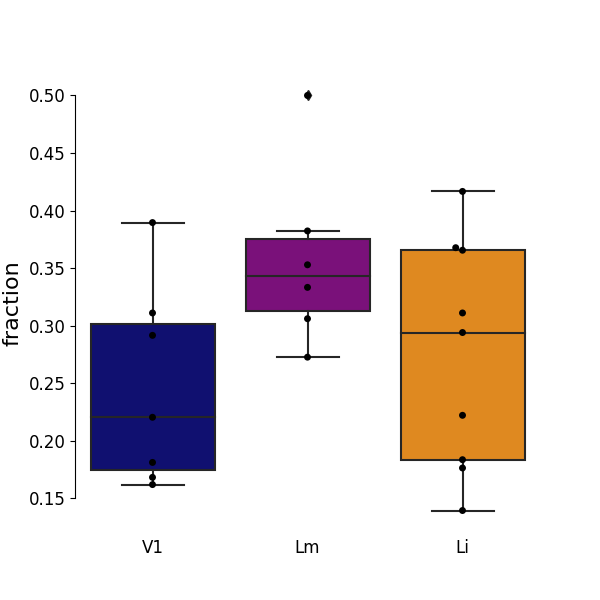

Text(0.5,0,u'')

In [117]:
fig, ax = pl.subplots(figsize=(6,6))

ax = sns.boxplot(x="visual_area", y="fraction", data=fraction_dev, 
                 palette=area_colors, ax=ax, order=visual_areas) #, alpha=0.7) #,\
                 #notch=True, bootstrap=10000)
    
# ax = sns.catplot(x='visual_area', y='fraction', data=fraction_dev,
#            palette=area_colors, order=visual_areas, kind='box')
sns.swarmplot(x='visual_area', y='fraction', data=fraction_dev, ax=ax, 
              color='k', s=5, marker='o',order=visual_areas) #palette=area_colors)

sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')

In [96]:
c1 = fraction_dev[fraction_dev['visual_area']=='V1']['fraction'].values
c2 = fraction_dev[fraction_dev['visual_area']=='Lm']['fraction'].values
c3 = fraction_dev[fraction_dev['visual_area']=='Li']['fraction'].values

# Shapiro-Wilk normality test 
print(spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

# Levene variance test  
print(spstats.levene(c1, c2, c3))


F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

import statsmodels.stats.multicomp as ml

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

((0.9409864544868469, 0.5321648120880127), (0.9155101180076599, 0.32102304697036743), (0.9564576148986816, 0.7448505759239197))
LeveneResult(statistic=0.85191839806281866, pvalue=0.43735766081786809)
F statistic = 0.928 and probability p = 0.407
(31,)
(31,)
(31,)
(31,)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.0181  -0.0984 0.1345 False 
  Li     V1   -0.0426  -0.1564 0.0712 False 
  Lm     V1   -0.0607  -0.1745 0.0531 False 
--------------------------------------------


In [97]:
ax = sns.boxplot(x="visual_area", y="fraction", data=fraction_dev, 
                 palette=area_colors, ax=ax, order=visual_areas) #, alpha=0.7) #,\
                 #notch=True, bootstrap=10000)

<IPython.core.display.Javascript object>


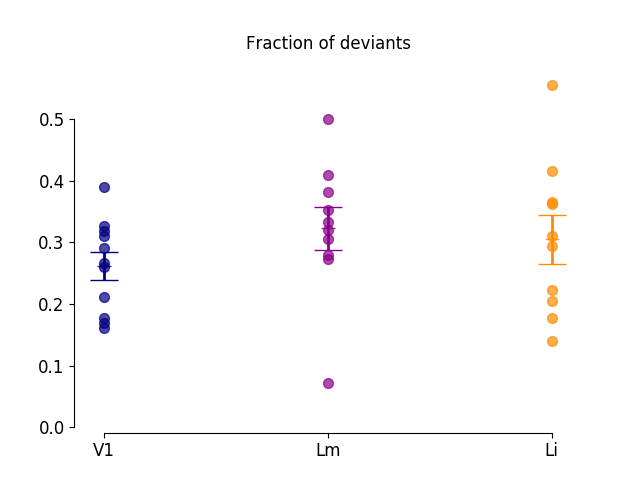

Text(0.5,1,u'Fraction of deviants')

In [98]:
fig, ax = pl.subplots()
vi = 0
for visual_area in visual_areas:
    g = fraction_dev[fraction_dev['visual_area']==visual_area]
    values = g['fraction'].values
    ax.scatter([vi for _ in range(len(values))], values,  marker='o', alpha=0.7, s=50,
               color=area_colors[visual_area])
              #edgecolor=area_colors[visual_area], facecolor='none')
        
    ax.plot(vi, values.mean(), marker='_', color=area_colors[visual_area], linewidth=2, markersize=10, alpha=0.8)
    ax.errorbar(vi, values.mean(), yerr=spstats.sem(values), ecolor=area_colors[visual_area], capsize=10, lw=2)
    #sns.boxplot(x=[vi for _ in range(len(values))], y=values, color=area_colors[visual_area])
    vi += 1
ax.set_ylim([0, .6])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(visual_areas)
sns.despine(ax=ax, trim=True, offset=4)

ax.set_title("Fraction of deviants")

#pl.savefig(os.path.join(outdir, 'fraction_deviants.svg'))

<IPython.core.display.Javascript object>


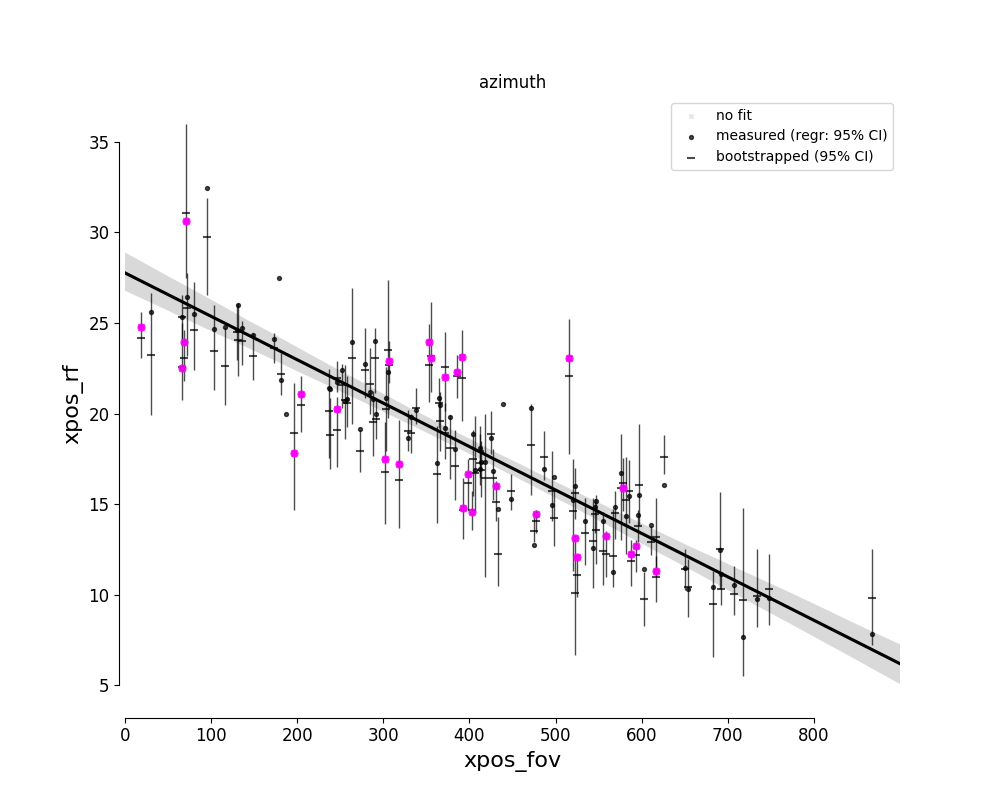

3


In [158]:
#### Calculate scatter

bootdata = bootresults['data']
bootcis = bootresults['cis']

x0_lower = bootcis['%s_lower' % parname][roi_list]
x0_upper = bootcis['%s_upper' % parname][roi_list]
for 
bootcis['x0_upper'] - bootcis['x0_lower']
    
posdf = fovinfo['positions']
xlim, ylim = fovinfo['xlim'], fovinfo['ylim']

#% # Plot bootstrapped param CIs + regression CI
xaxis_lim = max([xlim, ylim])
regresults={}


cond = 'azimuth'
fig, regr_cis, deviants, bad_fits = do_regr_on_fov(bootdata, bootcis, posdf, cond=cond, xaxis_lim=900)


In [159]:
outliers


[0,
 5,
 12,
 21,
 25,
 36,
 43,
 69,
 70,
 78,
 91,
 93,
 97,
 101,
 112,
 134,
 142,
 147,
 148,
 150,
 155,
 165,
 166,
 168,
 194,
 205,
 216,
 234]

## Compare gratings

In [161]:
fovdir = os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum)
osi_niters = 1000
osi_nsamples = 20

osi_str = 'fit-dff_all-cells_boot-%i-resample-%i' % (osi_niters, osi_nsamples)
osi_dir = glob.glob(os.path.join(fovdir, 'combined_gratings_static', 'traces', '%s*' % traceid, 'tuning', osi_str))[0]

os.listdir(osi_dir)

osi_eval_dfile = os.path.join(osi_dir, 'tuning_bootstrap_evaluation.pkl')
assert os.path.exists(osi_eval_dfile), "No evaulation found! %s" % osi_dir
with open(osi_eval_dfile, 'rb') as f:
    osi_eval = pkl.load(f)


In [162]:
osi_thr = 0.6
osi_mean_iters = osi_eval['fits'].groupby(['cell']).mean()
osi_fits = osi_mean_iters[osi_mean_iters['gof']>=osi_thr]
rois_osi = osi_fits.index.tolist()
print(len(rois_osi))

82


In [164]:
matched_rois = [r for r in rois_osi if r in outliers]
matched_rois

[5, 12, 21, 25, 91, 93, 112, 142, 147, 148, 166, 205, 216]

In [ ]:
osis_with_rfs = [r for r in roi_osi if r in ]

In [166]:
len(matched_rois) / float(len(rois_osi))


0.15853658536585366

In [48]:
estats.fovinfo.keys()

['roi_contours', 'positions', 'zimg', 'ylim', 'xlim']

In [21]:
rfdata[rfdata['animalid']=='JC080']

,index,animalid,experiment,fov,session,visual_area,exp_no,animal_no,path
25,95,JC080,rfs,FOV1_zoom2p0x,20190603,Lm,3,2,/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0...
26,103,JC080,rfs10,FOV2_zoom2p0x,20190602,Lm,4,2,/n/coxfs01/2p-data/JC080/20190602/FOV2_zoom2p0...
27,105,JC080,rfs10,FOV1_zoom2p0x,20190602,Li,4,2,/n/coxfs01/2p-data/JC080/20190602/FOV1_zoom2p0...


In [22]:
missing_rfs = []
dlist = []
for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
    skey = '-'.join([visual_area, animalid, session, fov])
    #print skey
    devpath = os.path.join( os.path.split(g['path'].values[0])[0], 'evaluation', 'deviants.json')
    if not os.path.exists(devpath):
        missing_rfs.append(devpath)
        continue
    else:
        with open(devpath, 'r') as f:
            d = json.load(f)

    dev_list = [('azimuth', i) for i in d['azimuth']]
    dev_list.extend( [('elevation', i) for i in d['elevation']] )
    dev_list.extend([('pass', i) for i in d['pass_rois']])
    tmpd = pd.DataFrame({'condition': [c[0] for c in dev_list],
                         'cell': [c[1] for c in dev_list],
                         'visual_area': [visual_area for _ in range(len(dev_list))],
                         'animalid': [animalid for _ in range(len(dev_list))],
                         'session': [session for _ in range(len(dev_list))],
                         'fov': [fov for _ in range(len(dev_list))]})
    
    dlist.append(tmpd)
    

In [23]:
print(len(missing_rfs))

1


In [24]:
for f in missing_rfs:
    print f.split('/traces/')[0]

/n/coxfs01/2p-data/JC080/20190602/FOV1_zoom2p0x/combined_rfs10_static


In [25]:
print(len(dlist))

25


In [26]:
df = pd.concat(dlist, axis=0).reset_index(drop=True)


In [27]:
df.groupby(['visual_area', 'condition']).count()['cell']

visual_area  condition
Li           azimuth      120
             elevation     93
             pass         165
Lm           azimuth      144
             elevation    139
             pass         238
V1           azimuth      190
             elevation    167
             pass         611
Name: cell, dtype: int64

In [28]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [29]:
df['ratio'] = [0 for _ in range(df.shape[0])]

In [30]:
#ratios = dict((visual_area, {'azimuth': [], 'elevation': []}) for visual_area in visual_areas)
for condition in ['azimuth', 'elevation']:
    for k, g in df.groupby(['visual_area', 'animalid', 'session', 'fov']):
        npass = len(g[g['condition']=='pass'])
        nbad = len(g[g['condition']==condition])
        frac = float(nbad)/npass
        df.loc[g.index, 'ratio'] = [frac for _ in range(g.shape[0])]
        #g['fraction'] = [frac for _ in range(g.shape[0])]
        
        #ratios[k[0]][condition].append(float(nbad)/npass)
        
        

In [31]:
df

,animalid,cell,condition,fov,session,visual_area,ratio
0,JC076,7,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
1,JC076,11,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
2,JC076,120,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
3,JC076,135,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
4,JC076,176,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
5,JC076,177,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
6,JC076,179,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
7,JC076,181,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
8,JC076,187,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
9,JC076,196,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000


In [32]:
for k, g in df[df['visual_area']=='Li'].groupby(['animalid', 'session']):
    print k

('JC076', '20190502')
('JC090', '20190605')
('JC091', '20190602')
('JC091', '20190614')
('JC099', '20190609')
('JC099', '20190612')
('JC099', '20190617')


<IPython.core.display.Javascript object>


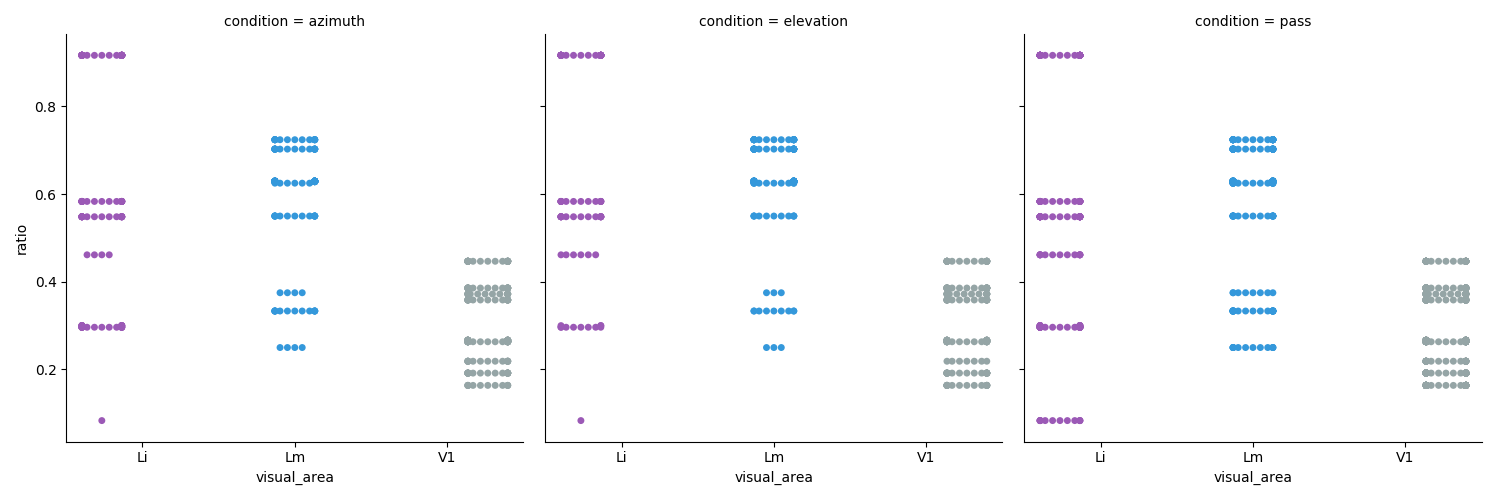

In [33]:
sns.catplot(x='visual_area', y='ratio', col='condition', hue='visual_area', data=df, \
            kind='swarm', dodge=True)

In [74]:
fracs_by_area = dict((visual_area, g.groupby(['animalid', 'session', 'fov'])['ratio'].unique().values.astype(float))\
                     for visual_area, g in df[df['condition']=='azimuth'].groupby(['visual_area']))
                     

In [75]:
df.head()

,animalid,cell,condition,fov,session,visual_area,ratio
0,JC076,7,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
1,JC076,11,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
2,JC076,120,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
3,JC076,135,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
4,JC076,176,azimuth,FOV1_zoom2p0x,20190502,Li,0.3


In [94]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/scatter'

<IPython.core.display.Javascript object>


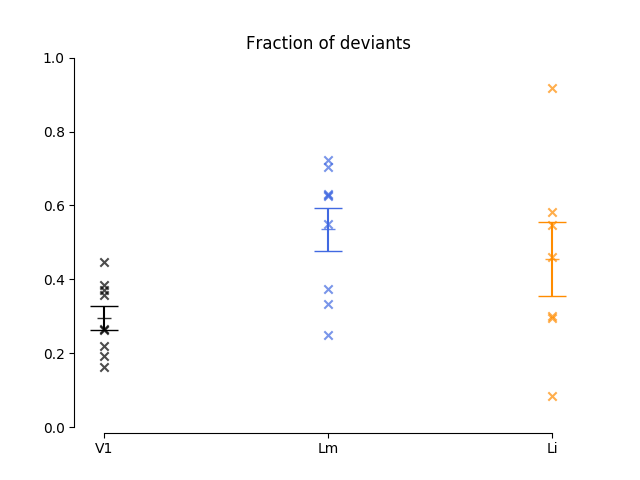

In [95]:
fig, ax = pl.subplots()

for vi, visual_area in enumerate(visual_areas):
    values = fracs_by_area[visual_area]
    ax.scatter([vi for _ in range(len(values))], values,  marker='x', color=area_colors[visual_area], alpha=0.7)
              #edgecolor=area_colors[visual_area], facecolor='none')
    ax.plot(vi, values.mean(), marker='_', color=area_colors[visual_area], markersize=10, alpha=0.8)
    ax.errorbar(vi, values.mean(), yerr=spstats.sem(values), ecolor=area_colors[visual_area], capsize=10)
    #sns.boxplot(x=[vi for _ in range(len(values))], y=values, color=area_colors[visual_area])
ax.set_ylim([0, 1])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(visual_areas)
sns.despine(ax=ax, trim=True, offset=4)

ax.set_title("Fraction of deviants")

pl.savefig(os.path.join(outdir, 'fraction_deviants.svg'))

In [40]:
g.groupby(['animalid', 'session', 'fov'])['ratio'].unique()

animalid  session   fov          
JC076     20190420  FOV1_zoom2p0x           [0.21875]
JC083     20190507  FOV1_zoom2p0x    [0.372093023256]
JC084     20190522  FOV1_zoom2p0x    [0.263157894737]
JC085     20190622  FOV1_zoom2p0x    [0.266666666667]
JC097     20190613  FOV1_zoom2p0x    [0.358490566038]
          20190615  FOV1_zoom2p0x    [0.191666666667]
                    FOV2_zoom2p0x    [0.163636363636]
          20190616  FOV1_zoom2p0x    [0.385714285714]
          20190617  FOV1_zoom2p0x    [0.446808510638]
Name: ratio, dtype: object

In [78]:
df.groupby(['visual_area', 'animalid', 'session', 'fov'])['ratio'].unique()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     [0.272727272727]
             JC090     20190605  FOV1_zoom2p0x    [0.0833333333333]
Lm           JC076     20190423  FOV1_zoom2p0x     [0.333333333333]
             JC078     20190426  FOV1_zoom2p0x      [0.62962962963]
                       20190430  FOV1_zoom2p0x     [0.724137931034]
                       20190513  FOV1_zoom2p0x     [0.733333333333]
             JC080     20190603  FOV1_zoom2p0x     [0.710526315789]
             JC083     20190508  FOV1_zoom2p0x     [0.611111111111]
             JC084     20190525  FOV1_zoom2p0x     [0.333333333333]
             JC091     20190627  FOV1_zoom2p0x              [0.375]
V1           JC076     20190420  FOV1_zoom2p0x     [0.266666666667]
             JC083     20190507  FOV1_zoom2p0x     [0.380952380952]
             JC084     20190522  FOV1_zoom2p0x     [0.272727272727]
             JC097     20190617  FOV1_zoom2p0x     [0.458333333333]
N